# Extend the Best 12M Model with Competitor Data

* Best model for 12M prediction: 10 features selected by SHAP + Boruta(Wrapper Method) + 1 lag Feature
* RMSE = 0.006415, MAE = 0.005216, MAPE = 2.480094 

In [1]:
import pandas as pd
import numpy as np
import csv
import seaborn as sns
from time import strptime

import matplotlib.pyplot as plt

import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from xgboost import plot_importance, plot_tree
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from BorutaShap import BorutaShap
import missingno as msno

#!pip install shap
import shap
shap.initjs()

(144, 97)
(144, 98)


<AxesSubplot:>

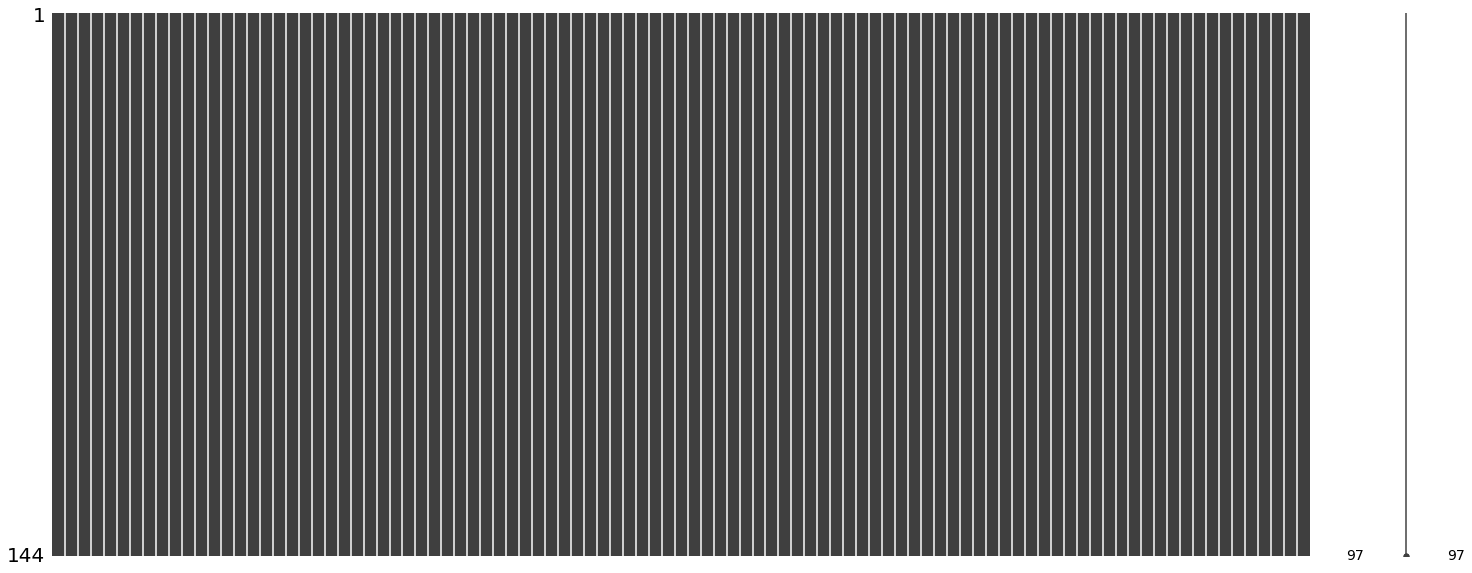

In [2]:
# load data
competitor_data = pd.read_csv("./data/08-19_v2.csv", index_col = [0])
competitor_data1 = pd.read_csv("./data/08-19_v2.csv")

competitor_data.index = pd.to_datetime(competitor_data.index)
competitor_data1["month"] = pd.to_datetime(competitor_data1["month"])

print(competitor_data.shape)
print(competitor_data1.shape)

msno.matrix(competitor_data)

## Feature Engeneering

In [3]:
def lag_feature(df, lags, new_df_col, target_col):
    tmp = df[new_df_col]
    for i in lags:
        tmp[target_col+'_lag_'+str(i)] = df[target_col].shift(i)
    
    tmp[target_col] = df[target_col]
    return tmp

def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            df[col].fillna(0, inplace=True)         
    return df

### Check Column Type

In [4]:
competitor_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 2008-01-01 to 2019-12-01
Data columns (total 97 columns):
 #   Column                                                                                    Non-Null Count  Dtype  
---  ------                                                                                    --------------  -----  
 0   aus_population_natural_increase                                                           144 non-null    float64
 1   aus_population_overseas_arrivals                                                          144 non-null    float64
 2   aus_population_net overseas migration                                                     144 non-null    float64
 3   aus_population_estimated resident population                                              144 non-null    float64
 4   aus_beef&veal_slaughterings                                                               144 non-null    float64
 5   aus_beef&veal_average weight          

## Train/ Test Split
### Cut off the data after 2019.6 to use as our test set.

In [4]:
xgb_Test_Accuracy_Data = pd.DataFrame(columns = ['feature','n_estimators','max_depth','min_child_weight',
                                                 'gamma','learning_rate','subsample','colsample_bytree',
                                                 'eta','RMSE','MAE', 'MAPE'])

In [6]:
competitor_data.columns

Index(['aus_population_natural_increase', 'aus_population_overseas_arrivals',
       'aus_population_net overseas migration',
       'aus_population_estimated resident population',
       'aus_beef&veal_slaughterings', 'aus_beef&veal_average weight',
       'aus_beef&veal_production', 'aus_beef&veal_exports',
       'aus_apparent consumption', 'australia cattle numbers',
       'aus_total dairy cattle and calves', 'aus_total beef cattle and calves',
       'aus_exports of beef, veal and live cattle to US',
       'Value of Australian exports of beef and veal, and live cattle to US',
       'us import of beef kt (cw)',
       'aus_Meat Produced ;  CATTLE (excl. calves) ;  Total (State) Original (tonnes)',
       'aus_Meat Produced ;  CATTLE (excl. calves) ;  Total (State) Seasonally adjusted (tonnes)',
       'aus_Meat Produced ;  CALVES ;  Total (State) ;',
       'aus_Meat Produced ;  CALVES ;  Total (State) ; Seasonally Adjusted',
       'aus_labour', 'aus_feed', 'aus_pasture', 'aus_

In [5]:
selected_features_shap_10 = ['aus_beef&veal_slaughterings', 'aus_population_natural_increase', 
                            'aus_beef&veal_exports', 'us_production_fedral_inspected_total red meat and poultry',
                            'aus_exports of beef, veal and live cattle to US', 
                            'us_livestock_commercial_mature sheep', 'us_livestock_commercial_beef',
                            'us_veganism_trend_ratio', 'us_fed_avg_dressed_calves','us_veganism','import_ratio']

selected_features_shap_month_10 = ['month','aus_beef&veal_slaughterings', 'aus_population_natural_increase', 
                            'aus_beef&veal_exports', 'us_production_fedral_inspected_total red meat and poultry',
                            'aus_exports of beef, veal and live cattle to US', 
                            'us_livestock_commercial_mature sheep', 'us_livestock_commercial_beef',
                            'us_veganism_trend_ratio', 'us_fed_avg_dressed_calves','us_veganism','import_ratio']

aus_us_ca_nz_features = ['aus_beef&veal_slaughterings', 'aus_population_natural_increase', 
                         'aus_beef&veal_exports', 'us_production_fedral_inspected_total red meat and poultry',
                         'aus_exports of beef, veal and live cattle to US', 
                         'us_livestock_commercial_mature sheep', 'us_livestock_commercial_beef',
                         'us_veganism_trend_ratio', 'us_fed_avg_dressed_calves','us_veganism',
                         'ca_beef_export_total', 'ca_beef_veal_prod', 'ca_beef_export_us',
                         'ca_population_natural_increase',
                         'nz_beef_export_total','nz_beef_veal_prod', 'nz_beef_export_us', 
                         'nz_population_natural_increase',
                         'import_ratio']



aus_us_ca_nz_features_month = ['month','aus_beef&veal_slaughterings', 'aus_population_natural_increase', 
                         'aus_beef&veal_exports', 'us_production_fedral_inspected_total red meat and poultry',
                         'aus_exports of beef, veal and live cattle to US', 
                         'us_livestock_commercial_mature sheep', 'us_livestock_commercial_beef',
                         'us_veganism_trend_ratio', 'us_fed_avg_dressed_calves','us_veganism',
                         'ca_beef_export_total', 'ca_beef_veal_prod', 'ca_beef_export_us',
                         'ca_population_natural_increase',
                         'nz_beef_export_total','nz_beef_veal_prod', 'nz_beef_export_us', 
                         'nz_population_natural_increase',
                         'import_ratio']


selected_df = competitor_data[aus_us_ca_nz_features]
idx = selected_df.shape[1]-1
selected_test_df = selected_df.iloc[132:144,:]
selected_train_df = selected_df.iloc[:132,:]

selected_X_train, selected_y_train = selected_train_df.iloc[:,:idx], selected_train_df.iloc[:,idx]
selected_X_test, selected_y_test = selected_test_df.iloc[:,:idx], selected_test_df.iloc[:,idx]


# has month: combine_data1
selected_df1 = competitor_data1[aus_us_ca_nz_features_month]
idx1 = selected_df1.shape[1]-1
selected_test_df1 = selected_df1.iloc[132:144,:]
selected_train_df1 = selected_df1.iloc[:132,:]

selected_X_train1, selected_y_train1 = selected_train_df1.iloc[:,:idx1], selected_train_df1.iloc[:,idx1]
selected_X_test1, selected_y_test1 = selected_test_df1.iloc[:,:idx1], selected_test_df1.iloc[:,idx1]
selected_X_test1


,month,aus_beef&veal_slaughterings,aus_population_natural_increase,aus_beef&veal_exports,us_production_fedral_inspected_total red meat and poultry,"aus_exports of beef, veal and live cattle to US",us_livestock_commercial_mature sheep,us_livestock_commercial_beef,us_veganism_trend_ratio,us_fed_avg_dressed_calves,us_veganism,ca_beef_export_total,ca_beef_veal_prod,ca_beef_export_us,ca_population_natural_increase,nz_beef_export_total,nz_beef_veal_prod,nz_beef_export_us,nz_population_natural_increase
132,2019-01-01,725.3,12.7,147.6,8939.67,20.1,9.26,261.90,0.53,121,81,44.939167,111.833333,63822.715501,24950.000000,32.596,68007780,38673,2500.000000
133,2019-02-01,725.3,12.7,147.6,7906.65,20.1,8.08,228.68,0.56,126,80,44.939167,111.833333,64241.681604,24950.000000,42.368,67512911,36599,2500.000000
134,2019-03-01,725.3,12.7,147.6,8334.81,20.1,9.28,251.74,0.57,125,76,44.939167,111.833333,79666.606110,24950.000000,48.874,71576883,46013,2500.000000
135,2019-04-01,725.3,11.5,147.6,8640.05,20.1,13.02,271.19,0.59,140,77,44.939167,111.833333,64681.283883,32570.333333,44.103,65605574,48889,2066.666667
136,2019-05-01,725.3,11.5,147.6,8905.95,20.1,12.58,271.71,0.58,136,73,44.939167,111.833333,69417.337114,32570.333333,51.713,87660282,57109,2066.666667
137,2019-06-01,725.3,11.5,147.6,8391.32,20.1,10.18,262.57,0.60,128,78,44.939167,111.833333,78274.904067,32570.333333,48.674,61854071,50257,2066.666667
138,2019-07-01,724.9,10.8,155.1,8970.29,20.0,11.60,266.56,0.58,117,74,44.939167,111.833333,71346.148298,59428.000000,38.094,43898906,40654,2000.000000
139,2019-08-01,724.9,10.8,155.1,9016.33,20.0,12.91,265.32,0.59,117,80,44.939167,111.833333,78710.596148,59428.000000,28.119,42200224,28538,2000.000000
140,2019-09-01,724.9,10.8,155.1,8602.12,20.0,11.01,258.27,0.57,123,75,44.939167,111.833333,72837.053386,59428.000000,26.378,38104771,14560,2000.000000
141,2019-10-01,724.9,11.4,155.1,9726.97,20.0,11.34,313.33,0.56,127,80,44.939167,111.833333,73516.131631,70056.333333,25.649,43875049,12702,2333.333333


In [54]:
len(aus_us_ca_nz_features_month)

20

In [32]:
model_BorutaShap_model = XGBRegressor()

# if classification is False it is a Regression problem
Feature_Selector = BorutaShap(model=model_BorutaShap_model,
                              importance_measure='shap',
                              classification=False)

#Feature_Selector.fit(X=X_train, y=y_train, n_trials=100, sample=False,
#                     train_or_test = 'test', verbose=True, random_state = 517)

Feature_Selector.fit(X=selected_X_train, y=selected_y_train, n_trials=100, verbose=True, random_state = 517)

  0%|          | 0/100 [00:00<?, ?it/s]

10 attributes confirmed important: ['us_production_fedral_inspected_total red meat and poultry', 'aus_exports of beef, veal and live cattle to US', 'aus_population_natural_increase', 'us_veganism_trend_ratio', 'aus_beef&veal_exports', 'us_livestock_commercial_mature sheep', 'aus_beef&veal_slaughterings', 'nz_beef_export_total', 'us_livestock_commercial_beef', 'us_fed_avg_dressed_calves']
8 attributes confirmed unimportant: ['ca_beef_slaughter', 'nz_beef_slaughter', 'ca_beef_veal_prod', 'nz_population_natural_increase', 'ca_beef_export_us', 'nz_beef_export_us', 'ca_population_natural_increase', 'nz_beef_veal_prod']
2 tentative attributes remains: ['ca_beef_export_total', 'us_veganism']


In [22]:
len(aus_us_ca_nz_features_month)

22

In [6]:
feature = 'US_AU_CA_NZ_noslau'

## Parameter Setting

# Number of trees
n_estimators = 206

# Maximum number of levels in tree
max_depth = 15

#minimum sum of weights of all observations required in a child
min_child_weight = 3

#Gamma specifies the minimum loss reduction required to make a split
gamma = 0

# boosting learning rate
learning_rate = 0.3572435914157277
subsample = 0.2001382655665839 # 80% of data to grow trees and prevent overfitting
colsample_bytree = 0.6522526338963393  # 85% of features used
eta = 0.1
seed = 517  # for reproducible results


xgb_reg = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate,
                       max_depth = max_depth, min_child_weight = min_child_weight,
                       gamma = gamma, subsample = subsample, colsample_bytree = colsample_bytree,
                       eta = eta, seed = seed, n_jobs=-1)

#Fit the regressor to the training set
#model_shap_sel_yes= xgb_reg.fit(selected_X_train, selected_y_train)

evaluation = [(selected_X_train, selected_y_train), (selected_X_test, selected_y_test)]
model_shap_sel_yes = xgb_reg.fit(selected_X_train, selected_y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)


# Train Data
# Use the forest's predict method on the train data
predictions_train = xgb_reg.predict(selected_X_train)

# Calculate the absolute errors
errors_train = abs(predictions_train - selected_y_train)

# Calculate mean absolute percentage error (MAPE)
mape_train = 100 * (errors_train/ selected_y_train)
            
# Calculate and display accuracy
accuracy_train = 100 - np.mean(mape_train)

# Test Data
# Use the forest's predict method on the test data
predictions_test = xgb_reg.predict(selected_X_test)

# Calculate the absolute errors
errors_test = abs(predictions_test - selected_y_test)

# Calculate mean absolute percentage error (MAPE)
mape_test = 100 * (errors_test/ selected_y_test)

# Calculate and display accuracy
accuracy_test = 100 - np.mean(mape_test)


xgb_Test_Accuracy_Data_One = pd.DataFrame(index = range(1),columns = ['feature','n_estimators','max_depth',
                                                                      'min_child_weight','gamma',
                                                                      'learning_rate','subsample',
                                                                      'colsample_bytree','eta',
                                                                      'RMSE','MAE','MAPE'])

xgb_Test_Accuracy_Data_One.loc[:,'feature'] = feature
xgb_Test_Accuracy_Data_One.loc[:,'n_estimators'] = n_estimators
xgb_Test_Accuracy_Data_One.loc[:,'max_depth'] = max_depth
xgb_Test_Accuracy_Data_One.loc[:,'min_child_weight'] = min_child_weight            
xgb_Test_Accuracy_Data_One.loc[:,'gamma'] = gamma
xgb_Test_Accuracy_Data_One.loc[:,'learning_rate'] = learning_rate
xgb_Test_Accuracy_Data_One.loc[:,'subsample'] = subsample       
xgb_Test_Accuracy_Data_One.loc[:,'colsample_bytree'] = colsample_bytree
xgb_Test_Accuracy_Data_One.loc[:,'eta'] = eta
#xgb_Test_Accuracy_Data_One.loc[:,'Train Accurcay'] = accuracy_train
#xgb_Test_Accuracy_Data_One.loc[:,'Test Accurcay'] = accuracy_test

# make predictions on the test set

predictions = xgb_reg.predict(selected_X_test)

selected_test_df['predictions'] = predictions
selected_test_df1['predictions'] = predictions

# compute the root mean sqaured error
rmse = np.sqrt(mean_squared_error(selected_y_test, predictions))

xgb_Test_Accuracy_Data_One.loc[:,'RMSE'] = rmse

mae = mean_absolute_error(selected_y_test, predictions)
xgb_Test_Accuracy_Data_One.loc[:,'MAE'] = mae

xgb_Test_Accuracy_Data_One.loc[:,'MAPE'] = np.mean(mape_test)

xgb_Test_Accuracy_Data = xgb_Test_Accuracy_Data.append(xgb_Test_Accuracy_Data_One)

xgb_Test_Accuracy_Data

,feature,n_estimators,max_depth,min_child_weight,gamma,learning_rate,subsample,colsample_bytree,eta,RMSE,MAE,MAPE
0,US_AU_CA_NZ_noslau,206,15,3,0,0.357244,0.200138,0.652253,0.1,0.034215,0.025007,12.876221


In [7]:
# create lag features for the best subset
lag_list = [1,13]

df = selected_df
new_df_col = df.columns[:-1]
target_col = 'import_ratio'

best_lag = lag_feature(df, lag_list, new_df_col, target_col)

best_lag = fill_na(best_lag)
best_lag



df1 = selected_df1
new_df_col1 = ['month']
tmp_name = df.columns[:-1]
for i in range(len(tmp_name)):
    new_df_col1.append(tmp_name[i])

target_col1 = 'import_ratio'

best_lag1 = lag_feature(df1, lag_list, new_df_col1, target_col1)
best_lag1 = fill_na(best_lag1)
best_lag1

## best feature with lag features
## Has outlier
# no month: 
stop_idx = best_lag.shape[1]-1

best_test_df_lag = best_lag.iloc[132:144,:]
best_train_df_lag = best_lag.iloc[:132,:]
best_X_train_lag, best_y_train_lag = best_train_df_lag.iloc[:,:stop_idx], best_train_df_lag.iloc[:,stop_idx]
best_X_test_lag, best_y_test_lag = best_test_df_lag.iloc[:,:stop_idx], best_test_df_lag.iloc[:,stop_idx]
# 3lags = 9

# has month: 
stop_idx1 = best_lag1.shape[1]-1

best_test_df1_lag = best_lag1.iloc[132:144,:]
best_train_df1_lag = best_lag1.iloc[:132,:]
best_X_train1_lag, best_y_train1_lag = best_train_df1_lag.iloc[:,:stop_idx1], best_train_df1_lag.iloc[:,stop_idx1]
best_X_test1_lag, best_y_test1_lag = best_test_df1_lag.iloc[:,:stop_idx1], best_test_df1_lag.iloc[:,stop_idx1]
# 3lags = 10

best_X_train_lag

,aus_beef&veal_slaughterings,aus_population_natural_increase,aus_beef&veal_exports,us_production_fedral_inspected_total red meat and poultry,"aus_exports of beef, veal and live cattle to US",us_livestock_commercial_mature sheep,us_livestock_commercial_beef,us_veganism_trend_ratio,us_fed_avg_dressed_calves,us_veganism,ca_beef_export_total,ca_beef_veal_prod,ca_beef_export_us,ca_population_natural_increase,nz_beef_export_total,nz_beef_veal_prod,nz_beef_export_us,nz_population_natural_increase,import_ratio_lag_1
month,,,,,,,,,,,,,,,,,,,
2008-01-01,722.7,14.0,120.0,8208.07,20.5,9.62,314.64,0.49,159,33,39.815833,108.666667,61682.424941,16158.333333,32.851,68426717,45364,3200.000000,0.00
2008-02-01,722.7,14.0,120.0,7406.19,20.5,9.03,255.12,0.60,160,49,39.815833,108.666667,64977.147454,16158.333333,41.271,67773893,50868,3200.000000,0.29
2008-03-01,722.7,14.0,120.0,7569.35,20.5,10.30,262.20,0.50,160,40,39.815833,108.666667,71609.785911,16158.333333,37.601,54554571,68963,3200.000000,0.15
2008-04-01,722.7,12.6,120.0,8025.23,20.5,11.11,286.80,0.54,164,32,39.815833,108.666667,69650.183909,25635.666667,36.553,69390263,49376,2833.333333,0.21
2008-05-01,722.7,12.6,120.0,7922.09,20.5,12.08,319.74,0.49,162,25,39.815833,108.666667,75686.375304,25635.666667,40.630,73995179,58539,2833.333333,0.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-01,725.3,11.1,147.6,9196.85,20.1,12.39,268.45,0.59,124,77,40.442500,105.416667,72255.318157,55551.000000,25.426,38159087,43169,2000.000000,0.22
2018-09-01,725.3,11.1,147.6,8044.41,20.1,9.19,235.57,0.55,123,71,40.442500,105.416667,73930.178398,55551.000000,22.518,32948357,18110,2000.000000,0.25
2018-10-01,725.3,12.0,147.6,9398.13,20.1,10.56,284.00,0.54,134,73,40.442500,105.416667,67486.185785,61767.000000,20.171,43537309,20499,2300.000000,0.26


In [12]:
100%|██████████| 3000/3000 [21:11<00:00,  2.36trial/s, best loss: 0.010594643440238584]
The best hyperparameters are :  

{'colsample_bytree': 0.775289838006837, 'learning_rate': 0.5273002765726296, 
 'max_depth': 12.0, 'min_child_weight': 5.0, 'n_estimators': 1708.0, 'subsample': 0.3995896274246257}

SyntaxError: invalid syntax (<ipython-input-12-17d94d544cac>, line 1)

In [8]:
feature = 'US_AU_CA_NZ_LAG_noslau'

## Parameter Setting

# Number of trees
n_estimators = 518

# Maximum number of levels in tree
max_depth = 15

#minimum sum of weights of all observations required in a child
min_child_weight = 1

#Gamma specifies the minimum loss reduction required to make a split
gamma = 0

# boosting learning rate
learning_rate = 0.6802414794084608
subsample = 0.6083882361120225 # 80% of data to grow trees and prevent overfitting
colsample_bytree = 0.8179152785753151  # 85% of features used
eta = 0.1
seed = 517  # for reproducible results

xgb_reg = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate,
                       max_depth = max_depth, min_child_weight = min_child_weight,
                       gamma = gamma, subsample = subsample, colsample_bytree = colsample_bytree,
                       eta = eta, seed = seed)

#Fit the regressor to the training set
#best_model= xgb_reg.fit(X_train_lag, y_train_lag)

evaluation = [(best_X_train_lag, best_y_train_lag), (best_X_test_lag, best_y_test_lag)]
best_model = xgb_reg.fit(best_X_train_lag, best_y_train_lag,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)


# Train Data
# Use the forest's predict method on the train data
predictions_train = xgb_reg.predict(best_X_train_lag)

# Calculate the absolute errors
errors_train = abs(predictions_train - best_y_train_lag)

# Calculate mean absolute percentage error (MAPE)
mape_train = 100 * (errors_train/ best_y_train_lag)
            
# Calculate and display accuracy
accuracy_train = 100 - np.mean(mape_train)

# Test Data
# Use the forest's predict method on the test data
predictions_test = xgb_reg.predict(best_X_test_lag)

# Calculate the absolute errors
errors_test = abs(predictions_test - best_y_test_lag)

# Calculate mean absolute percentage error (MAPE)
mape_test = 100 * (errors_test/ best_y_test_lag)

# Calculate and display accuracy
accuracy_test = 100 - np.mean(mape_test)


xgb_Test_Accuracy_Data_One = pd.DataFrame(index = range(1),columns = ['feature','n_estimators','max_depth',
                                                                      'min_child_weight','gamma',
                                                                      'learning_rate','subsample',
                                                                      'colsample_bytree','eta',
                                                                      'RMSE','MAE','MAPE'])

xgb_Test_Accuracy_Data_One.loc[:,'feature'] = feature
xgb_Test_Accuracy_Data_One.loc[:,'n_estimators'] = n_estimators
xgb_Test_Accuracy_Data_One.loc[:,'max_depth'] = max_depth
xgb_Test_Accuracy_Data_One.loc[:,'min_child_weight'] = min_child_weight            
xgb_Test_Accuracy_Data_One.loc[:,'gamma'] = gamma
xgb_Test_Accuracy_Data_One.loc[:,'learning_rate'] = learning_rate
xgb_Test_Accuracy_Data_One.loc[:,'subsample'] = subsample       
xgb_Test_Accuracy_Data_One.loc[:,'colsample_bytree'] = colsample_bytree
xgb_Test_Accuracy_Data_One.loc[:,'eta'] = eta                                                                    
#xgb_Test_Accuracy_Data_One.loc[:,'Train Accurcay'] = accuracy_train
#xgb_Test_Accuracy_Data_One.loc[:,'Test Accurcay'] = accuracy_test

# make predictions on the test set

predictions = xgb_reg.predict(best_X_test_lag)

best_test_df_lag['predictions'] = predictions
best_test_df1_lag['predictions'] = predictions

# compute the root mean sqaured error
rmse = np.sqrt(mean_squared_error(best_y_test_lag, predictions))

xgb_Test_Accuracy_Data_One.loc[:,'RMSE'] = rmse

mae = mean_absolute_error(best_y_test_lag, predictions)
xgb_Test_Accuracy_Data_One.loc[:,'MAE'] = mae
xgb_Test_Accuracy_Data_One.loc[:,'MAPE'] = np.mean(mape_test)

xgb_Test_Accuracy_Data = xgb_Test_Accuracy_Data.append(xgb_Test_Accuracy_Data_One)
   
xgb_Test_Accuracy_Data

,feature,n_estimators,max_depth,min_child_weight,gamma,learning_rate,subsample,colsample_bytree,eta,RMSE,MAE,MAPE
0,US_AU_CA_NZ_noslau,206,15,3,0,0.357244,0.200138,0.652253,0.1,0.034215,0.025007,12.876221
0,US_AU_CA_NZ_LAG_noslau,518,15,1,0,0.680241,0.608388,0.817915,0.1,0.022061,0.018082,8.307182


In [10]:
e = best_y_train_lag - predictions_train

pd.DataFrame(e).to_csv("12m_redsidual_2008-2018_Dec.csv")
#plt.scatter(e, predictions_train)

In [9]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe


# Initialize domain space for range of values
space={'max_depth': hp.quniform("max_depth", 10, 15, 1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform ('n_estimators', 200, 3000, 1),
       'learning_rate': hp.uniform ('learning_rate', 0.01, 0.8),
       'subsample': hp.uniform ('subsample', 0.2,0.8),
        'seed': 517}

# Define objective function 
def objective(space):
    xgb_reg=xgb.XGBRegressor(n_estimators =int(space['n_estimators']), max_depth = int(space['max_depth']),
                             gamma = 0,
                             min_child_weight=space['min_child_weight'],
                             colsample_bytree=space['colsample_bytree'], 
                             learning_rate=space['learning_rate'],subsample=space['subsample'],
                             eta=0.1, seed = 517)
    
    #xgb_reg.fit(best_X_train_lag, best_y_train_lag)

    evaluation = [(best_X_train_lag, best_y_train_lag), (best_X_test_lag, best_y_test_lag)]
    
    xgb_reg.fit(best_X_train_lag, best_y_train_lag,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)

    predictions = xgb_reg.predict(best_X_test_lag)
    rmse = np.sqrt(mean_squared_error(best_y_test_lag, predictions))
    mae = mean_absolute_error(best_y_test_lag, predictions)
    #mse= mean_squared_error(y_test, pred)
    #print ("rmse:", rmse)
    #print ("mae:", mae)

    return {'loss':rmse, 'status': STATUS_OK, 'model': xgb_reg}


# Optimization algorithm
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 3000,
                        trials = trials)

# print results
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

100%|██████████| 3000/3000 [41:06<00:00,  1.22trial/s, best loss: 0.011493410436433146] 
The best hyperparameters are :  

{'colsample_bytree': 0.650622805542529, 'learning_rate': 0.50897109305158, 'max_depth': 14.0, 'min_child_weight': 1.0, 'n_estimators': 1961.0, 'subsample': 0.4670723535185362}


In [ ]:
12 lag
100%|██████████| 3000/3000 [35:07<00:00,  1.42trial/s, best loss: 0.008676988701504835] 
The best hyperparameters are :  

{'colsample_bytree': 0.6050589707509273, 'learning_rate': 0.7263616228780148,
 'max_depth': 12.0, 'min_child_weight': 6.0, 'n_estimators': 2320.0, 'subsample': 0.7471875896939539}

In [ ]:
1 lag
100%|██████████| 3000/3000 [55:22<00:00,  1.11s/trial, best loss: 0.0068548904096823165] 
The best hyperparameters are :  

{'colsample_bytree': 0.7864370599947497, 'learning_rate': 0.7768002498823771, 
 'max_depth': 13.0, 'min_child_weight': 7.0, 'n_estimators': 2246.0, 'subsample': 0.2992930179213669}

In [ ]:
1,12 lag
100%|██████████| 3000/3000 [36:46<00:00,  1.36trial/s, best loss: 0.010237547565769061] 
The best hyperparameters are :  

{'colsample_bytree': 0.8220968665751636, 'learning_rate': 0.6829734578468802,
 'max_depth': 12.0, 'min_child_weight': 5.0, 'n_estimators': 2326.0, 'subsample': 0.5408164872431489}

In [ ]:
3 lags

100%|██████████| 3000/3000 [27:37<00:00,  1.81trial/s, best loss: 0.00876143665914846]   
The best hyperparameters are :  

{'colsample_bytree': 0.6737250696893877, 'learning_rate': 0.5964796998223377,
 'max_depth': 13.0, 'min_child_weight': 6.0, 'n_estimators': 253.0, 'subsample': 0.4361192654883142}

In [ ]:
2 lags
100%|██████████| 3000/3000 [30:26<00:00,  1.64trial/s, best loss: 0.008912996649419306] 
The best hyperparameters are :  

{'colsample_bytree': 0.6743735369860405, 'learning_rate': 0.5789129522053116, 
 'max_depth': 13.0, 'min_child_weight': 6.0, 'n_estimators': 2440.0, 'subsample': 0.2595808361442331}

In [ ]:
1 lag
100%|██████████| 3000/3000 [21:11<00:00,  2.36trial/s, best loss: 0.010594643440238584]
The best hyperparameters are :  

{'colsample_bytree': 0.775289838006837, 'learning_rate': 0.5273002765726296,
 'max_depth': 12.0, 'min_child_weight': 5.0, 'n_estimators': 1708.0, 'subsample': 0.3995896274246257}

## Finally, validate model on different time ranges
- April - Sept 2014
- May - Oct 2016
- Jan - June 2016

In [57]:
# create lag features for the best subset
lag_list = [1]

df = selected_df
new_df_col = df.columns[:-1]
target_col = 'import_ratio'

best_lag = lag_feature(df, lag_list, new_df_col, target_col)

best_lag = fill_na(best_lag)
best_lag


df1 = selected_df1
new_df_col1 = ['month']
tmp_name = df.columns[:-1]
for i in range(len(tmp_name)):
    new_df_col1.append(tmp_name[i])

target_col1 = 'import_ratio'

best_lag1 = lag_feature(df1, lag_list, new_df_col1, target_col1)
best_lag1 = fill_na(best_lag1)
best_lag1

,month,aus_beef&veal_slaughterings,aus_population_natural_increase,aus_beef&veal_exports,us_production_fedral_inspected_total red meat and poultry,"aus_exports of beef, veal and live cattle to US",us_livestock_commercial_mature sheep,us_livestock_commercial_beef,us_veganism_trend_ratio,us_fed_avg_dressed_calves,...,ca_beef_export_total,ca_beef_veal_prod,ca_beef_export_us,ca_population_natural_increase,nz_beef_export_total,nz_beef_veal_prod,nz_beef_export_us,nz_population_natural_increase,import_ratio_lag_1,import_ratio
0,2008-01-01,722.7,14.0,120.0,8208.07,20.5,9.62,314.64,0.49,159,...,39.815833,108.666667,61682.424941,16158.333333,32.851,68426717,45364,3200.000000,0.00,0.29
1,2008-02-01,722.7,14.0,120.0,7406.19,20.5,9.03,255.12,0.60,160,...,39.815833,108.666667,64977.147454,16158.333333,41.271,67773893,50868,3200.000000,0.29,0.15
2,2008-03-01,722.7,14.0,120.0,7569.35,20.5,10.30,262.20,0.50,160,...,39.815833,108.666667,71609.785911,16158.333333,37.601,54554571,68963,3200.000000,0.15,0.21
3,2008-04-01,722.7,12.6,120.0,8025.23,20.5,11.11,286.80,0.54,164,...,39.815833,108.666667,69650.183909,25635.666667,36.553,69390263,49376,2833.333333,0.21,0.27
4,2008-05-01,722.7,12.6,120.0,7922.09,20.5,12.08,319.74,0.49,162,...,39.815833,108.666667,75686.375304,25635.666667,40.630,73995179,58539,2833.333333,0.27,0.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,2019-08-01,724.9,10.8,155.1,9016.33,20.0,12.91,265.32,0.59,117,...,44.939167,111.833333,78710.596148,59428.000000,28.119,42200224,28538,2000.000000,0.25,0.25
140,2019-09-01,724.9,10.8,155.1,8602.12,20.0,11.01,258.27,0.57,123,...,44.939167,111.833333,72837.053386,59428.000000,26.378,38104771,14560,2000.000000,0.25,0.25
141,2019-10-01,724.9,11.4,155.1,9726.97,20.0,11.34,313.33,0.56,127,...,44.939167,111.833333,73516.131631,70056.333333,25.649,43875049,12702,2333.333333,0.25,0.25
142,2019-11-01,724.9,11.4,155.1,8657.12,20.0,11.16,298.08,0.61,130,...,44.939167,111.833333,72632.120109,70056.333333,31.654,58573203,11342,2333.333333,0.25,0.24


In [60]:
## best feature with lag features
## Has outlier
# no month: 
stop_idx = best_lag.shape[1]-1

# create new train set and validation set
#val_df_lag = best_lag.iloc[72:84,:] # 2014
val_df_lag = best_lag.iloc[96:108,:]  # 2016
all_train_df_lag = best_lag

all_X_train_lag, all_y_train_lag = all_train_df_lag.iloc[:,:stop_idx], all_train_df_lag.iloc[:,stop_idx]
X_val_lag, y_val_lag = val_df_lag.iloc[:,:stop_idx], val_df_lag.iloc[:,stop_idx]


# has month: 
stop_idx1 = best_lag1.shape[1]-1

# create new train set and validation set
#val_df1_lag = best_lag1.iloc[72:84,:]  # 2014
val_df1_lag = best_lag1.iloc[96:108,:]    # 2016
all_train_df1_lag = best_lag1

all_X_train1_lag, all_y_train1_lag = all_train_df1_lag.iloc[:,:stop_idx1], all_train_df1_lag.iloc[:,stop_idx1]
X_val1_lag, y_val1_lag = val_df1_lag.iloc[:,:stop_idx1], val_df1_lag.iloc[:,stop_idx1]


X_val1_lag

,month,aus_beef&veal_slaughterings,aus_population_natural_increase,aus_beef&veal_exports,us_production_fedral_inspected_total red meat and poultry,"aus_exports of beef, veal and live cattle to US",us_livestock_commercial_mature sheep,us_livestock_commercial_beef,us_veganism_trend_ratio,us_fed_avg_dressed_calves,us_veganism,ca_beef_export_total,ca_beef_veal_prod,ca_beef_export_us,ca_population_natural_increase,nz_beef_export_total,nz_beef_veal_prod,nz_beef_export_us,nz_population_natural_increase,import_ratio_lag_1
96,2016-01-01,733.3,14.2,145.8,7804.17,28.0,7.80,200.13,0.45,161,51,35.245,94.166667,53558.443552,16080.666667,36.309,60698074,63881,2666.666667,0.28
97,2016-02-01,733.3,14.2,145.8,7631.78,28.0,8.59,191.26,0.50,168,52,35.245,94.166667,52459.335961,16080.666667,38.176,56824266,62008,2666.666667,0.37
98,2016-03-01,733.3,14.2,145.8,8312.47,28.0,9.14,210.52,0.53,178,54,35.245,94.166667,60234.207167,16080.666667,41.916,70306707,66204,2666.666667,0.23
99,2016-04-01,733.3,13.0,145.8,7787.94,28.0,10.29,202.31,0.55,173,56,35.245,94.166667,61333.772368,33055.666667,42.178,70523817,65743,2400.000000,0.29
100,2016-05-01,733.3,13.0,145.8,7982.69,28.0,11.14,212.90,0.56,168,58,35.245,94.166667,57799.527564,33055.666667,48.793,80333281,76913,2400.000000,0.28
101,2016-06-01,733.3,13.0,145.8,8268.80,28.0,11.48,221.97,0.58,171,59,35.245,94.166667,56540.557275,33055.666667,47.013,57974439,75172,2400.000000,0.26
102,2016-07-01,618.4,11.8,120.3,7610.32,17.0,8.82,194.62,0.55,149,56,35.245,94.166667,60939.870779,46394.666667,30.587,34762962,68546,2266.666667,0.28
103,2016-08-01,618.4,11.8,120.3,8631.98,17.0,11.72,213.49,0.55,148,54,35.245,94.166667,72030.264029,46394.666667,24.285,44271132,36919,2266.666667,0.26
104,2016-09-01,618.4,11.8,120.3,8292.99,17.0,11.29,214.40,0.52,145,51,35.245,94.166667,67821.000767,46394.666667,22.361,35810024,23273,2266.666667,0.25
105,2016-10-01,618.4,12.1,120.3,8372.49,17.0,10.25,238.42,0.50,137,54,35.245,94.166667,70717.475570,49746.333333,19.745,32630257,26006,2466.666667,0.20


In [61]:
feature = '2016vali'

## Parameter Setting

# Number of trees
n_estimators = 518

# Maximum number of levels in tree
max_depth = 15
#minimum sum of weights of all observations required in a child
min_child_weight = 1

#Gamma specifies the minimum loss reduction required to make a split
gamma = 0

# boosting learning rate
learning_rate = 0.6802414794084608
subsample = 0.6083882361120225 # 80% of data to grow trees and prevent overfitting
colsample_bytree = 0.8179152785753151  # 85% of features used
eta = 0.1
seed = 517  # for reproducible results


xgb_reg = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate,
                       max_depth = max_depth, min_child_weight = min_child_weight,
                       gamma = gamma, subsample = subsample, colsample_bytree = colsample_bytree,
                       eta = eta, seed = seed)

#Fit the regressor to the training set
#best_model= xgb_reg.fit(X_train_lag, y_train_lag)

evaluation = [(all_X_train_lag, all_y_train_lag), (X_val_lag, y_val_lag)]
vali_model = xgb_reg.fit(all_X_train_lag, all_y_train_lag,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)


# Train Data
# Use the forest's predict method on the train data
predictions_train = xgb_reg.predict(all_X_train_lag)

# Calculate the absolute errors
errors_train = abs(predictions_train - all_y_train_lag)

# Calculate mean absolute percentage error (MAPE)
mape_train = 100 * (errors_train/ all_y_train_lag)
            
# Calculate and display accuracy
accuracy_train = 100 - np.mean(mape_train)

# Test Data
# Use the forest's predict method on the test data
predictions_test = xgb_reg.predict(X_val_lag)

# Calculate the absolute errors
errors_test = abs(predictions_test - y_val_lag)

# Calculate mean absolute percentage error (MAPE)
mape_test = 100 * (errors_test/ y_val_lag)

# Calculate and display accuracy
accuracy_test = 100 - np.mean(mape_test)


xgb_Test_Accuracy_Data_One = pd.DataFrame(index = range(1),columns = ['feature','n_estimators','max_depth',
                                                                      'min_child_weight','gamma',
                                                                      'learning_rate','subsample',
                                                                      'colsample_bytree','eta',
                                                                      'RMSE','MAE','MAPE'])

xgb_Test_Accuracy_Data_One.loc[:,'feature'] = feature
xgb_Test_Accuracy_Data_One.loc[:,'n_estimators'] = n_estimators
xgb_Test_Accuracy_Data_One.loc[:,'max_depth'] = max_depth
xgb_Test_Accuracy_Data_One.loc[:,'min_child_weight'] = min_child_weight            
xgb_Test_Accuracy_Data_One.loc[:,'gamma'] = gamma
xgb_Test_Accuracy_Data_One.loc[:,'learning_rate'] = learning_rate
xgb_Test_Accuracy_Data_One.loc[:,'subsample'] = subsample       
xgb_Test_Accuracy_Data_One.loc[:,'colsample_bytree'] = colsample_bytree
xgb_Test_Accuracy_Data_One.loc[:,'eta'] = eta                                                                    


# make predictions on the test set

predictions = xgb_reg.predict(X_val_lag)

val_df_lag['predictions'] = predictions
val_df1_lag['predictions'] = predictions

# compute the root mean sqaured error
rmse = np.sqrt(mean_squared_error(y_val_lag, predictions))

xgb_Test_Accuracy_Data_One.loc[:,'RMSE'] = rmse

mae = mean_absolute_error(y_val_lag, predictions)
xgb_Test_Accuracy_Data_One.loc[:,'MAE'] = mae
xgb_Test_Accuracy_Data_One.loc[:,'MAPE'] = np.mean(mape_test)

xgb_Test_Accuracy_Data = xgb_Test_Accuracy_Data.append(xgb_Test_Accuracy_Data_One)

print(round(np.mean(mape_test),6))
xgb_Test_Accuracy_Data

0.131186


,feature,n_estimators,max_depth,min_child_weight,gamma,learning_rate,subsample,colsample_bytree,eta,RMSE,MAE,MAPE
0,US_AU_CA_NZ_has_slaughter,206,15,3,0,0.357244,0.200138,0.652253,0.1,0.025524,0.020212,9.642280
0,US_AU_CA_NZ_LAG,518,15,1,0,0.680241,0.608388,0.817915,0.1,0.025073,0.018578,9.298835
0,US_AU_CA_NZ_LAG_has_slaughter,518,15,1,0,0.680241,0.608388,0.817915,0.1,0.025073,0.018578,9.298835
0,US_AU_CA_NZ_no_slaughter,206,15,3,0,0.357244,0.200138,0.652253,0.1,0.034215,0.025007,12.876221
0,US_AU_CA_NZ_LAG_no_slaughter,518,15,1,0,0.680241,0.608388,0.817915,0.1,0.022061,0.018082,8.307182
0,US_AU_CA_NZ_only_exp_tt,206,15,3,0,0.357244,0.200138,0.652253,0.1,0.024097,0.021717,9.758449
0,US_AU_CA_NZ_LAG_only_exp_tt,518,15,1,0,0.680241,0.608388,0.817915,0.1,0.034234,0.022457,12.087503
0,US_AU_CA_NZ_exp_tt&pop,206,15,3,0,0.357244,0.200138,0.652253,0.1,0.028011,0.021452,10.643149
0,US_AU_CA_NZ_LAG_exp_tt&pop,518,15,1,0,0.680241,0.608388,0.817915,0.1,0.033246,0.025154,12.684196
0,US_AU_CA_NZ_exp_tt&pop&prod,206,15,3,0,0.357244,0.200138,0.652253,0.1,0.021591,0.018315,8.763672


# Prediction Plots

In [62]:
xgb_Test_Accuracy_Data

,feature,n_estimators,max_depth,min_child_weight,gamma,learning_rate,subsample,colsample_bytree,eta,RMSE,MAE,MAPE
0,US_AU_CA_NZ_has_slaughter,206,15,3,0,0.357244,0.200138,0.652253,0.1,0.025524,0.020212,9.642280
0,US_AU_CA_NZ_LAG,518,15,1,0,0.680241,0.608388,0.817915,0.1,0.025073,0.018578,9.298835
0,US_AU_CA_NZ_LAG_has_slaughter,518,15,1,0,0.680241,0.608388,0.817915,0.1,0.025073,0.018578,9.298835
0,US_AU_CA_NZ_no_slaughter,206,15,3,0,0.357244,0.200138,0.652253,0.1,0.034215,0.025007,12.876221
0,US_AU_CA_NZ_LAG_no_slaughter,518,15,1,0,0.680241,0.608388,0.817915,0.1,0.022061,0.018082,8.307182
0,US_AU_CA_NZ_only_exp_tt,206,15,3,0,0.357244,0.200138,0.652253,0.1,0.024097,0.021717,9.758449
0,US_AU_CA_NZ_LAG_only_exp_tt,518,15,1,0,0.680241,0.608388,0.817915,0.1,0.034234,0.022457,12.087503
0,US_AU_CA_NZ_exp_tt&pop,206,15,3,0,0.357244,0.200138,0.652253,0.1,0.028011,0.021452,10.643149
0,US_AU_CA_NZ_LAG_exp_tt&pop,518,15,1,0,0.680241,0.608388,0.817915,0.1,0.033246,0.025154,12.684196
0,US_AU_CA_NZ_exp_tt&pop&prod,206,15,3,0,0.357244,0.200138,0.652253,0.1,0.021591,0.018315,8.763672


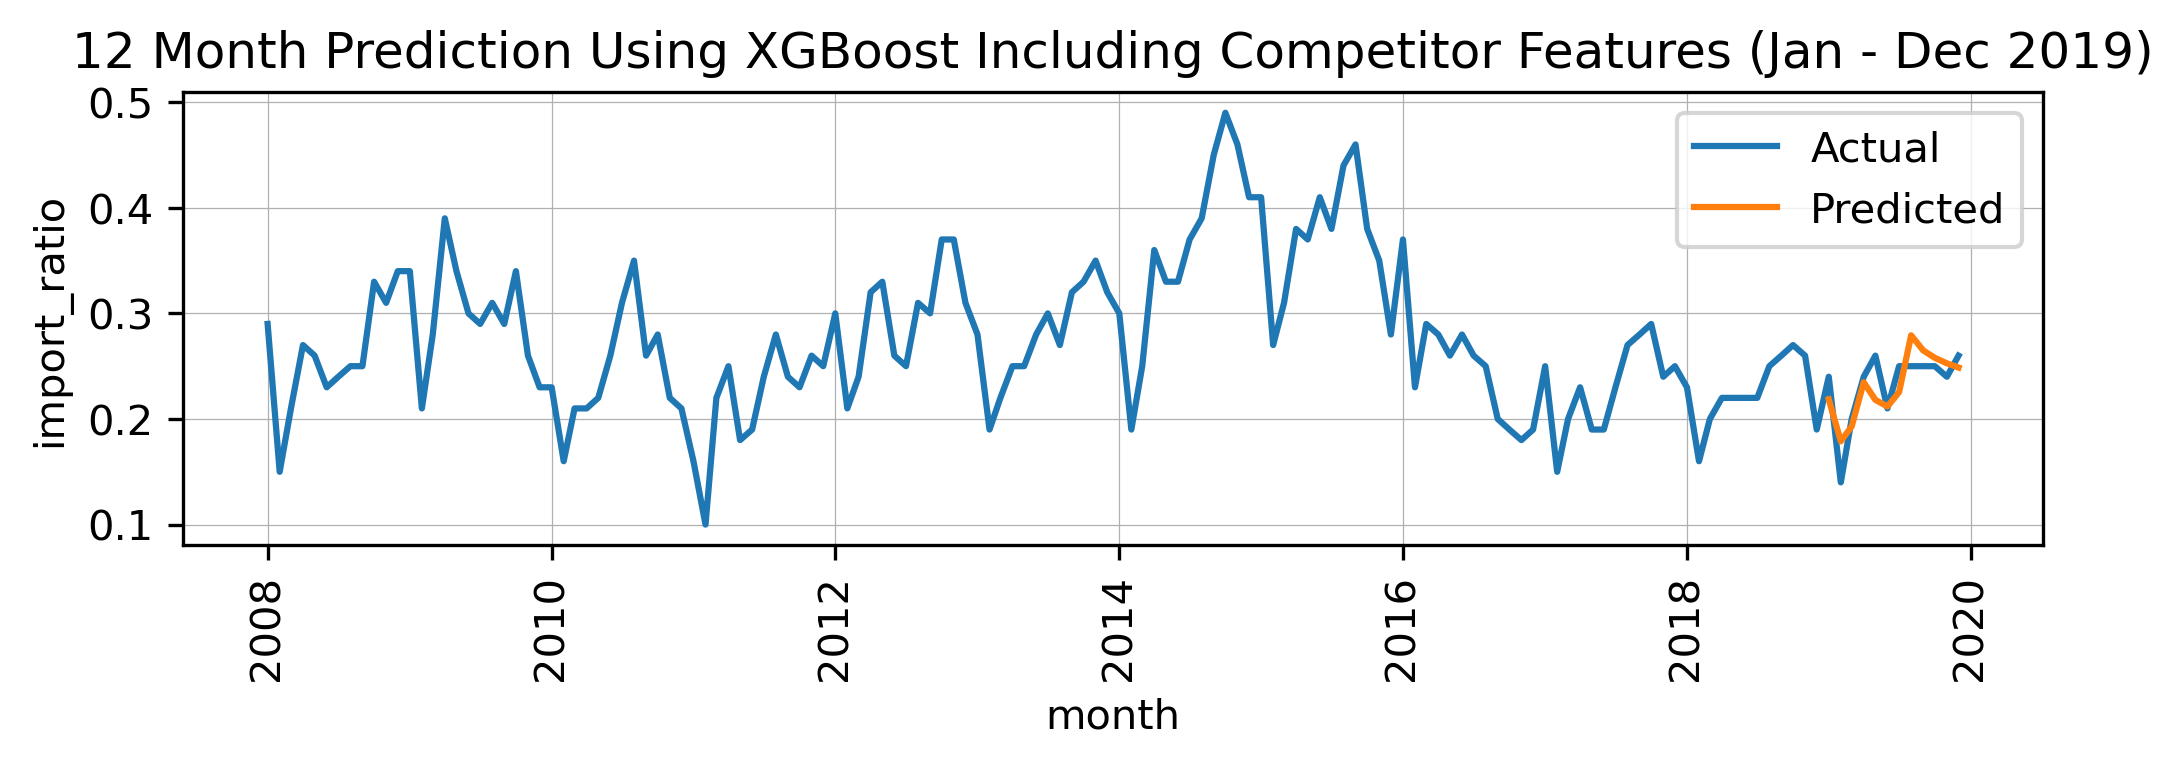

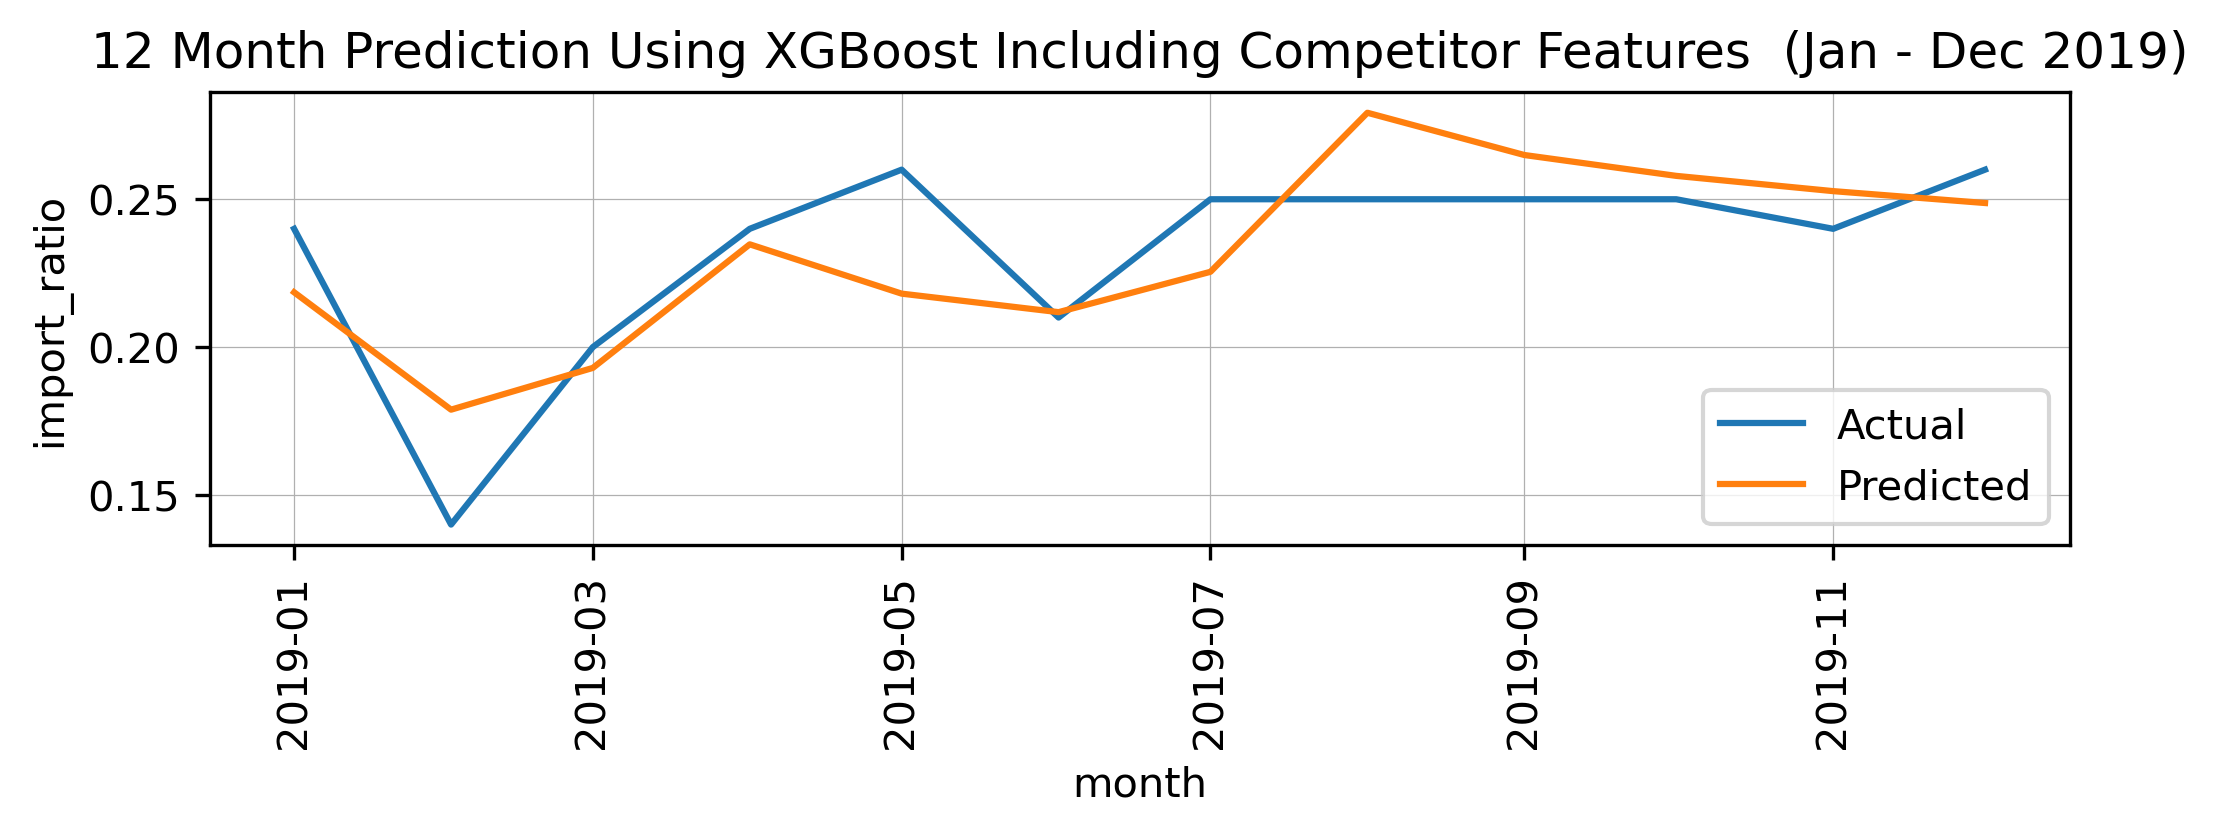

In [15]:
# HAS OUTLIER & 1 Lag feature + 18 features(us, au, ca, nz)
plt.rcParams.update({'figure.figsize': (8, 2), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=best_lag1, x='month', y='import_ratio')
sns.lineplot(data=best_test_df1_lag, x='month', y='predictions').set_title("12 Month Prediction Using XGBoost Including Competitor Features (Jan - Dec 2019)")
ax.legend(['Actual', 'Predicted'])
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

# zoom in
# simple one
plt.rcParams.update({'figure.figsize': (8, 2), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=best_test_df1_lag, x='month', y='import_ratio')
sns.lineplot(data=best_test_df1_lag, x='month', y='predictions').set_title("12 Month Prediction Using XGBoost Including Competitor Features  (Jan - Dec 2019)")
ax.legend(['Actual', 'Predicted'])
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

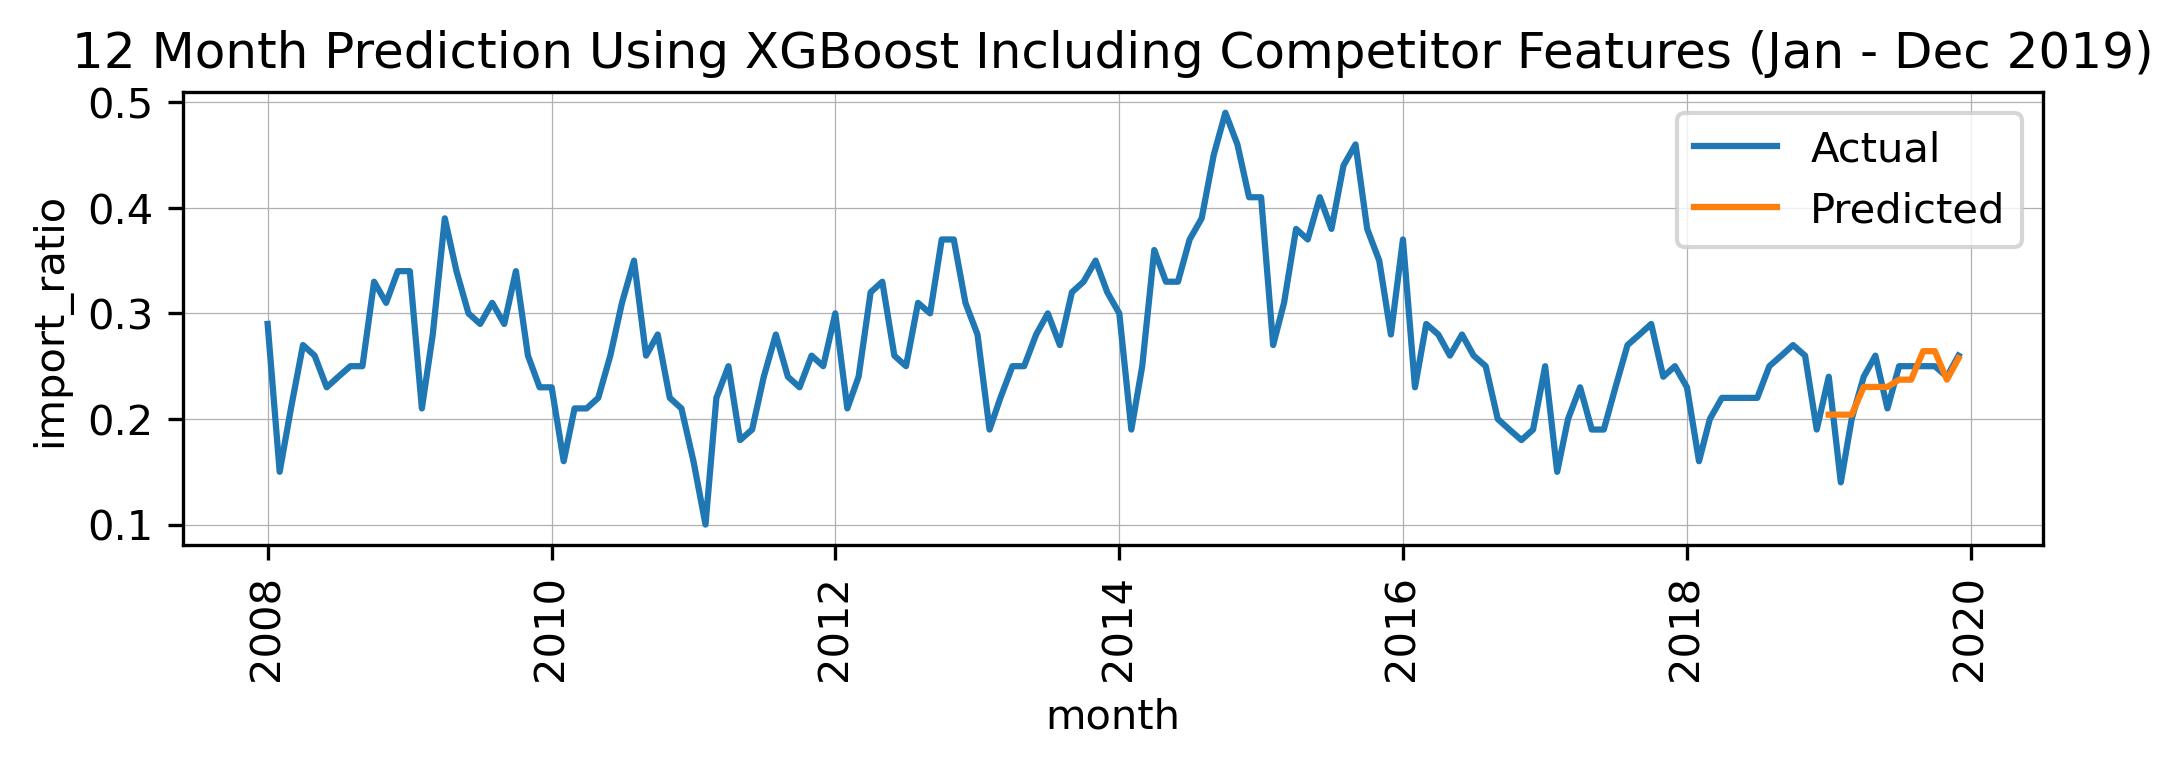

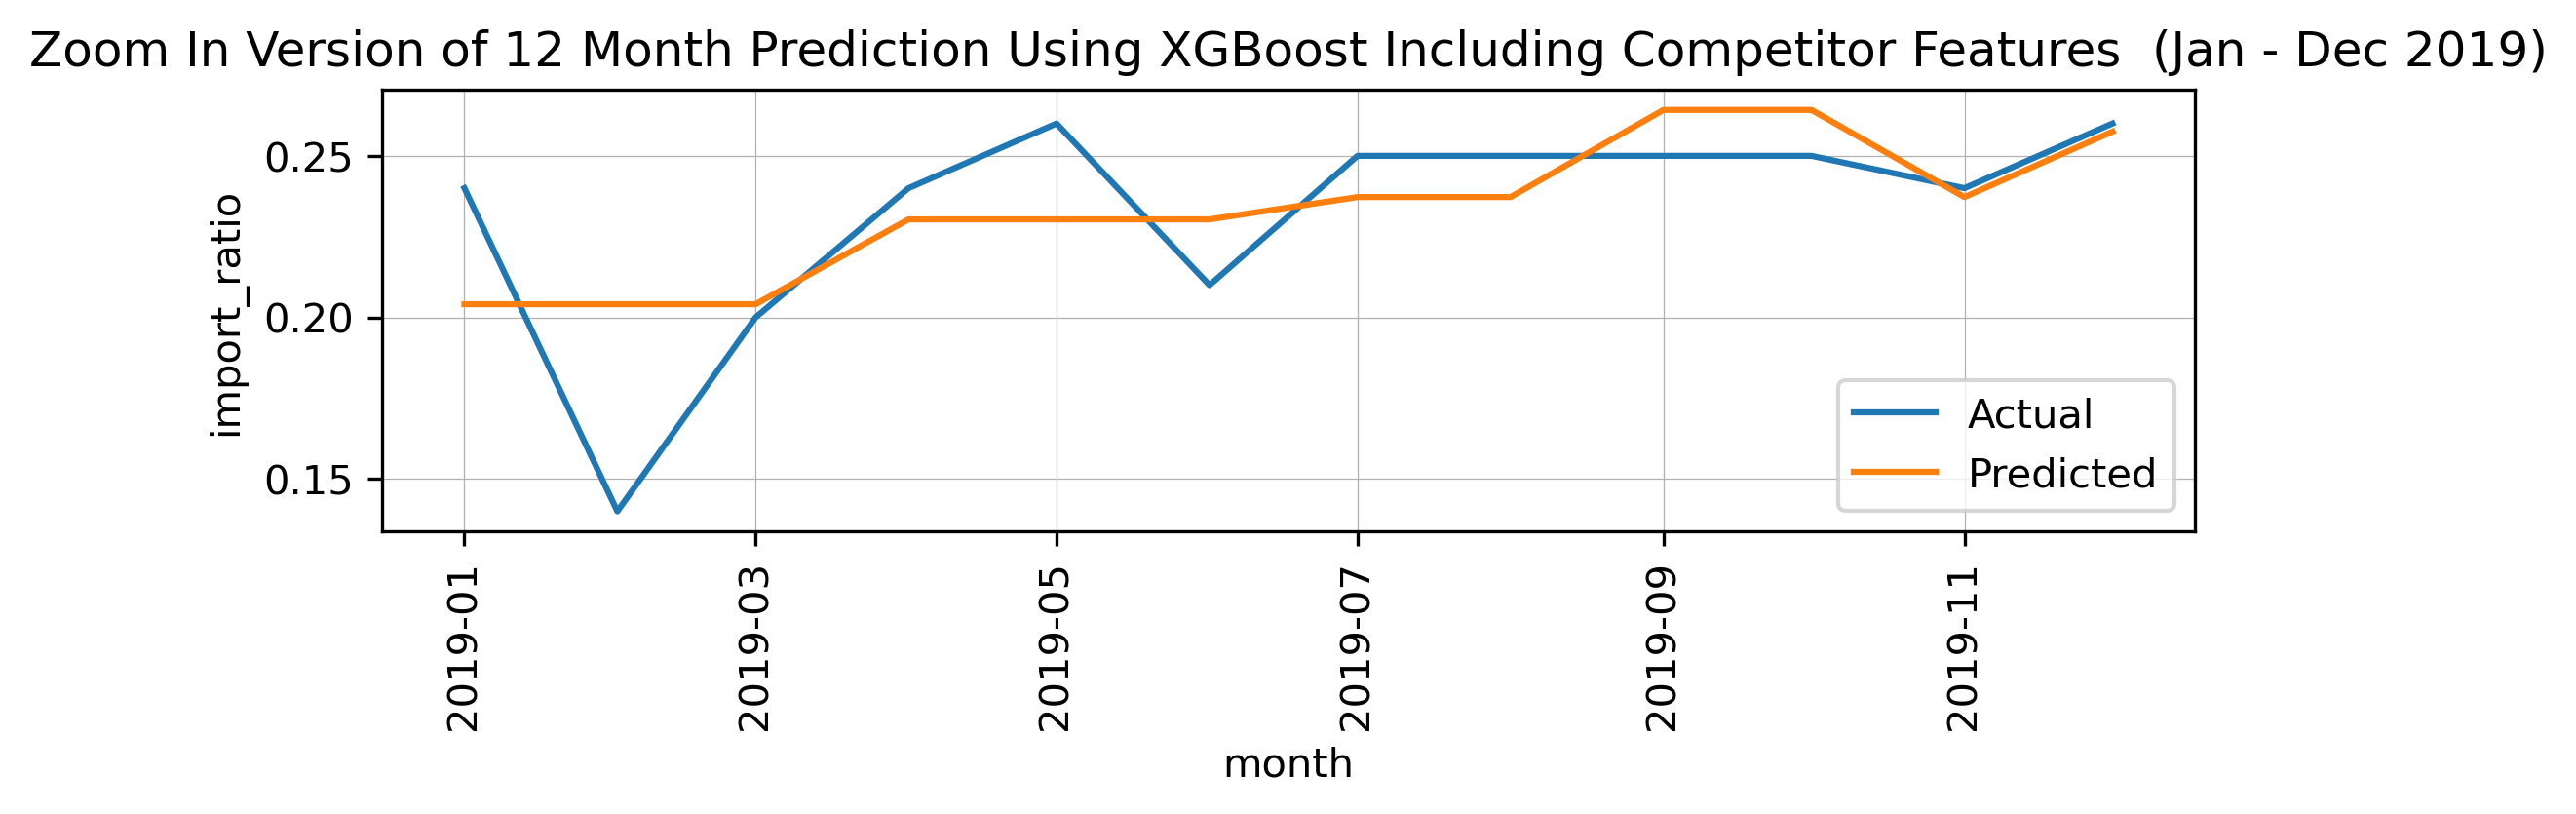

In [19]:
# HAS OUTLIER & 1 Lag feature + 20 features(us, au, ca, nz)
plt.rcParams.update({'figure.figsize': (8, 2), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=best_lag1, x='month', y='import_ratio')
sns.lineplot(data=best_test_df1_lag, x='month', y='predictions').set_title("12 Month Prediction Using XGBoost Including Competitor Features (Jan - Dec 2019)")
ax.legend(['Actual', 'Predicted'])
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

# zoom in
# simple one
plt.rcParams.update({'figure.figsize': (8, 2), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=best_test_df1_lag, x='month', y='import_ratio')
sns.lineplot(data=best_test_df1_lag, x='month', y='predictions').set_title("Zoom In Version of 12 Month Prediction Using XGBoost Including Competitor Features  (Jan - Dec 2019)")
ax.legend(['Actual', 'Predicted'])
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

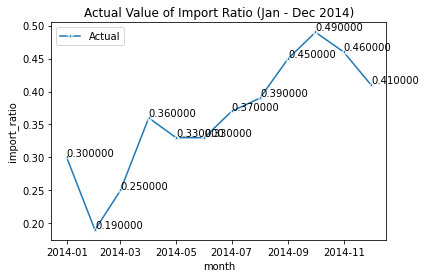

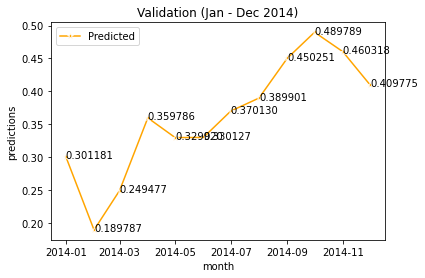

In [43]:
%matplotlib inline
from matplotlib.ticker import FormatStrFormatter

# HAS OUTLIER & Lag feature + shap selected features(17) & 2014 validation
plt.show()

#plt.rcParams.update({'figure.figsize': (5, 2), 'figure.dpi':300})
fig, ax = plt.subplots()
a = sns.lineplot(data=val_df1_lag, x='month',
                 y='import_ratio',marker='*').set_title("Actual Value of Import Ratio (Jan - Dec 2014)")

#ax.set_xlabel('Month', fontsize=7)
#ax.set_ylabel('Import Ratio', fontsize=7)

# label points on the plot
for x, y in zip(val_df1_lag['month'], val_df1_lag['import_ratio']):
     plt.text(x = x, 
             y = y+0.0025, 
             s = '{:.6f}'.format(y), fontsize=10)
        
ax.legend(['Actual']) 


#plt.rcParams.update({'figure.figsize': (5, 2), 'figure.dpi':300})
fig, ax = plt.subplots()

b = sns.lineplot(data=val_df1_lag, x='month', y='predictions', 
                 marker='*', color = 'orange').set_title("Validation (Jan - Dec 2014)")


# label points on the plot
for x, y in zip(val_df1_lag['month'], val_df1_lag['predictions']):
    plt.text(x = x, 
          y = y-0.0025, 
          s = '{:.6f}'.format(y), fontsize=10)

ax.legend(['Predicted'])

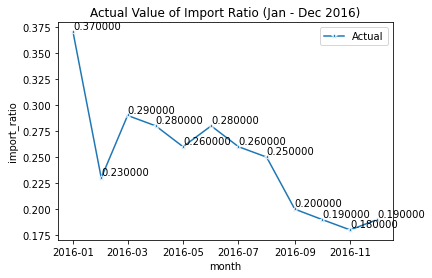

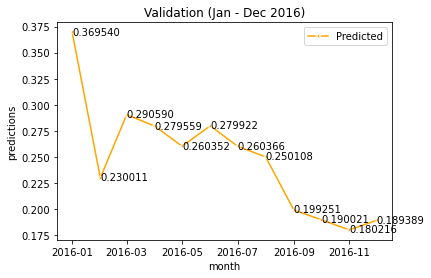

In [48]:
%matplotlib inline
from matplotlib.ticker import FormatStrFormatter

# HAS OUTLIER & Lag feature + shap selected features(17) & 2016 validation
plt.show()

#plt.rcParams.update({'figure.figsize': (5, 2), 'figure.dpi':300})
fig, ax = plt.subplots()
a = sns.lineplot(data=val_df1_lag, x='month',
                 y='import_ratio',marker='*').set_title("Actual Value of Import Ratio (Jan - Dec 2016)")

#ax.set_xlabel('Month', fontsize=7)
#ax.set_ylabel('Import Ratio', fontsize=7)

# label points on the plot
for x, y in zip(val_df1_lag['month'], val_df1_lag['import_ratio']):
     plt.text(x = x, 
             y = y+0.0025, 
             s = '{:.6f}'.format(y), fontsize=10)
        
ax.legend(['Actual']) 


#plt.rcParams.update({'figure.figsize': (5, 2), 'figure.dpi':300})
fig, ax = plt.subplots()

b = sns.lineplot(data=val_df1_lag, x='month', y='predictions', 
                 marker='*', color = 'orange').set_title("Validation (Jan - Dec 2016)")


# label points on the plot
for x, y in zip(val_df1_lag['month'], val_df1_lag['predictions']):
    plt.text(x = x, 
          y = y-0.0025, 
          s = '{:.6f}'.format(y), fontsize=10)

ax.legend(['Predicted'])

## Model Output Explaination Using Shap

In [18]:
# compute the SHAP values for every prediction in the validation dataset
explainer_has_outlier = shap.TreeExplainer(best_model)
shap_values_has_outlier = explainer_has_outlier(best_X_test_lag)
#shap_values = explainer.shap_values(X_importance)

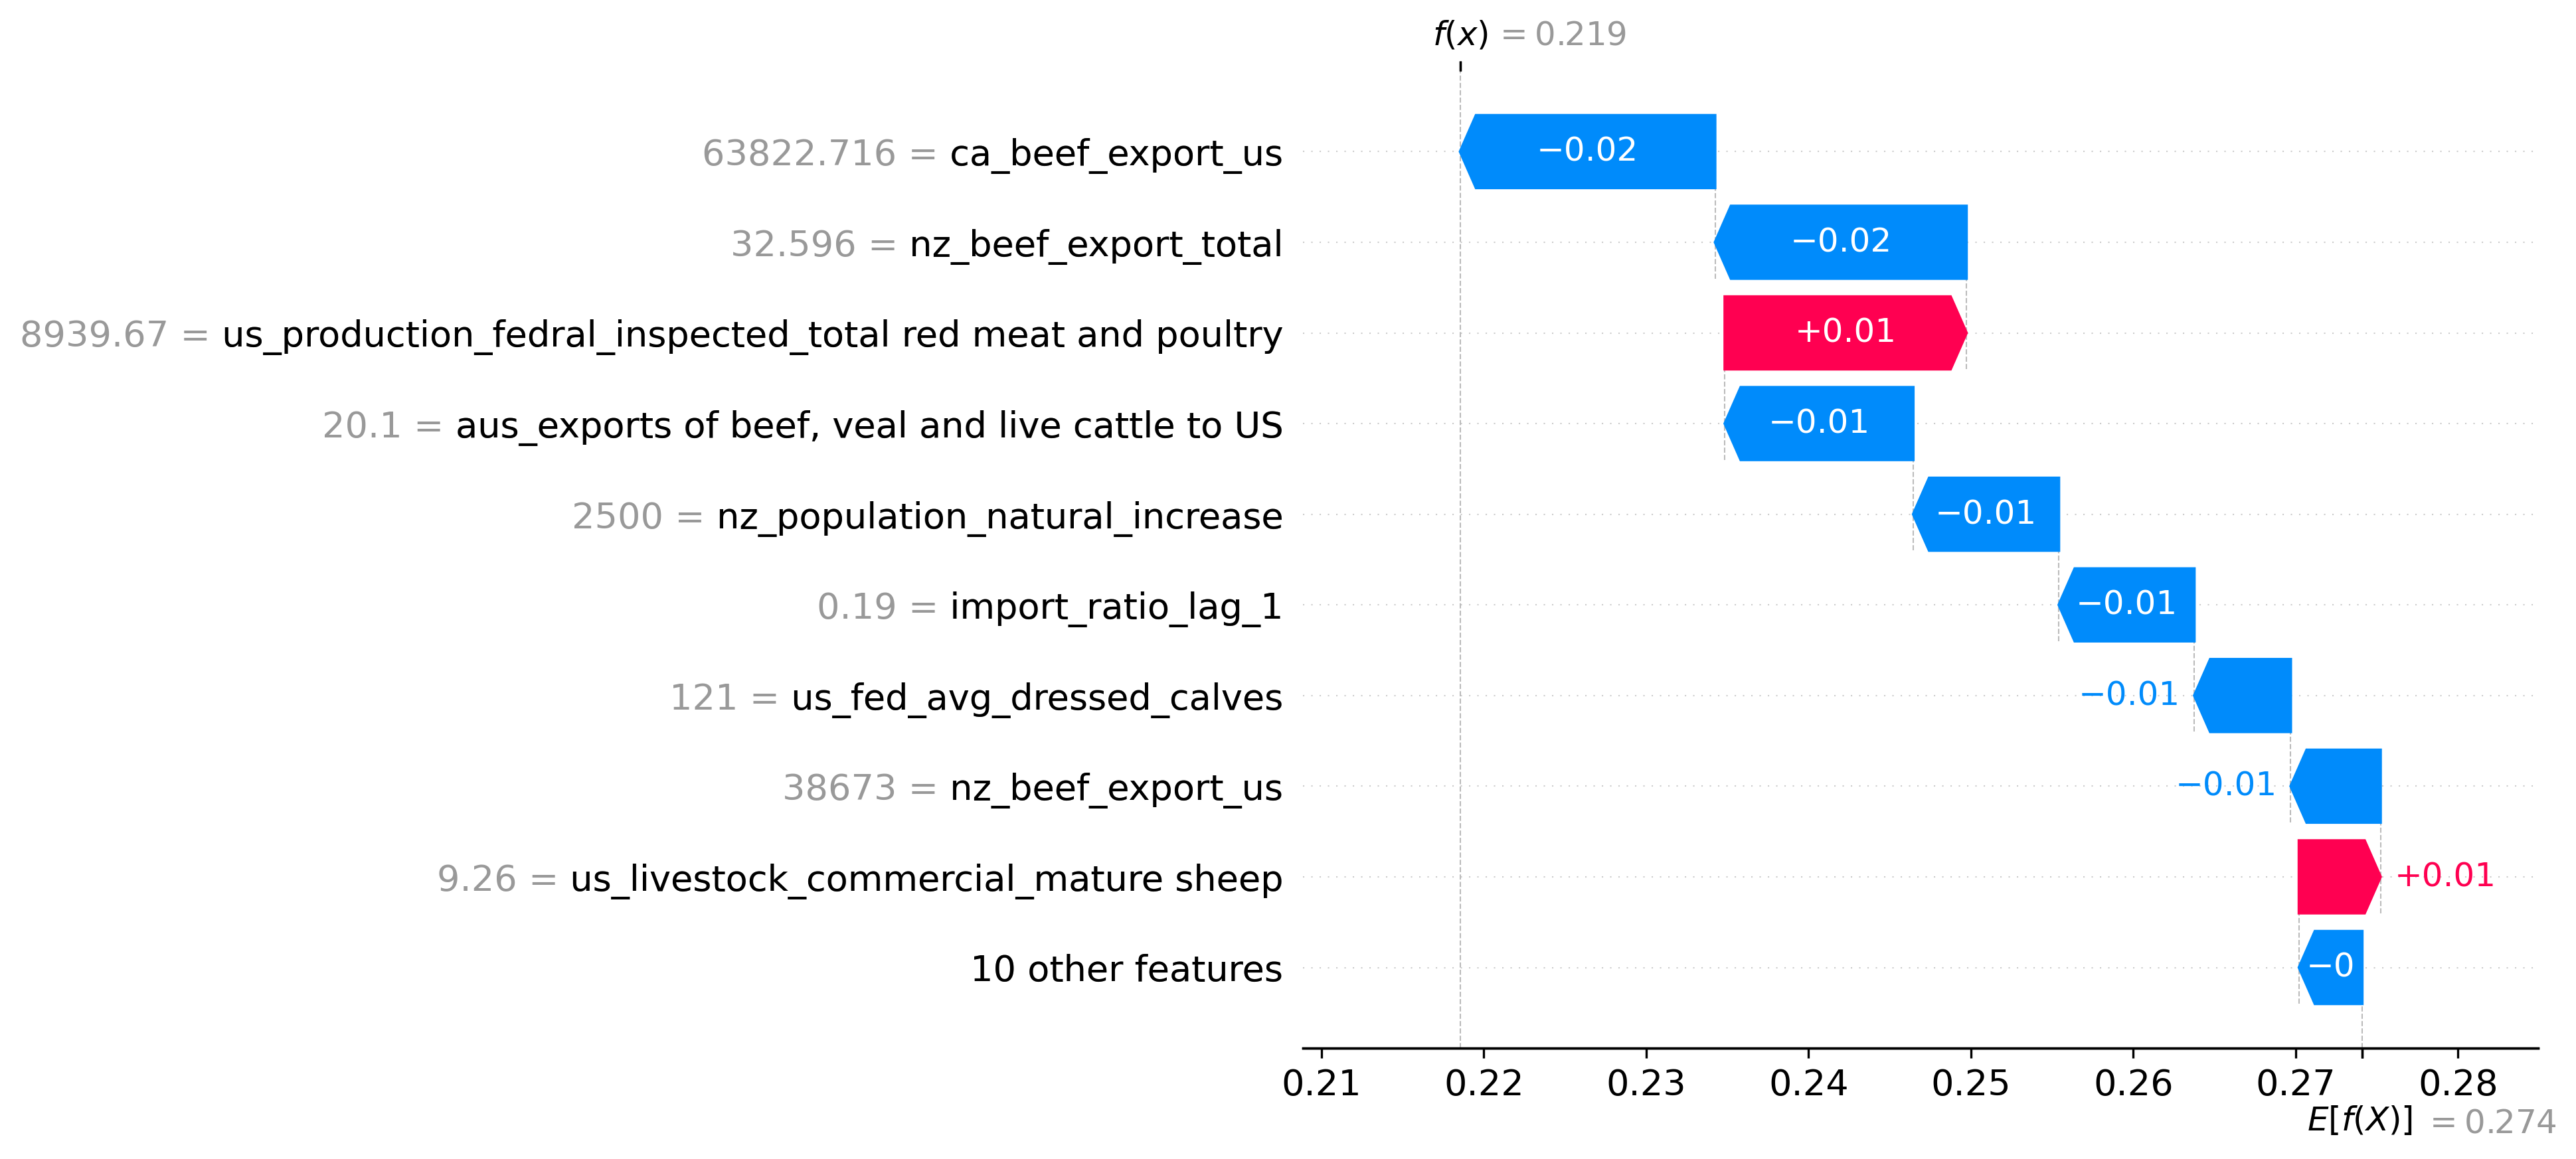

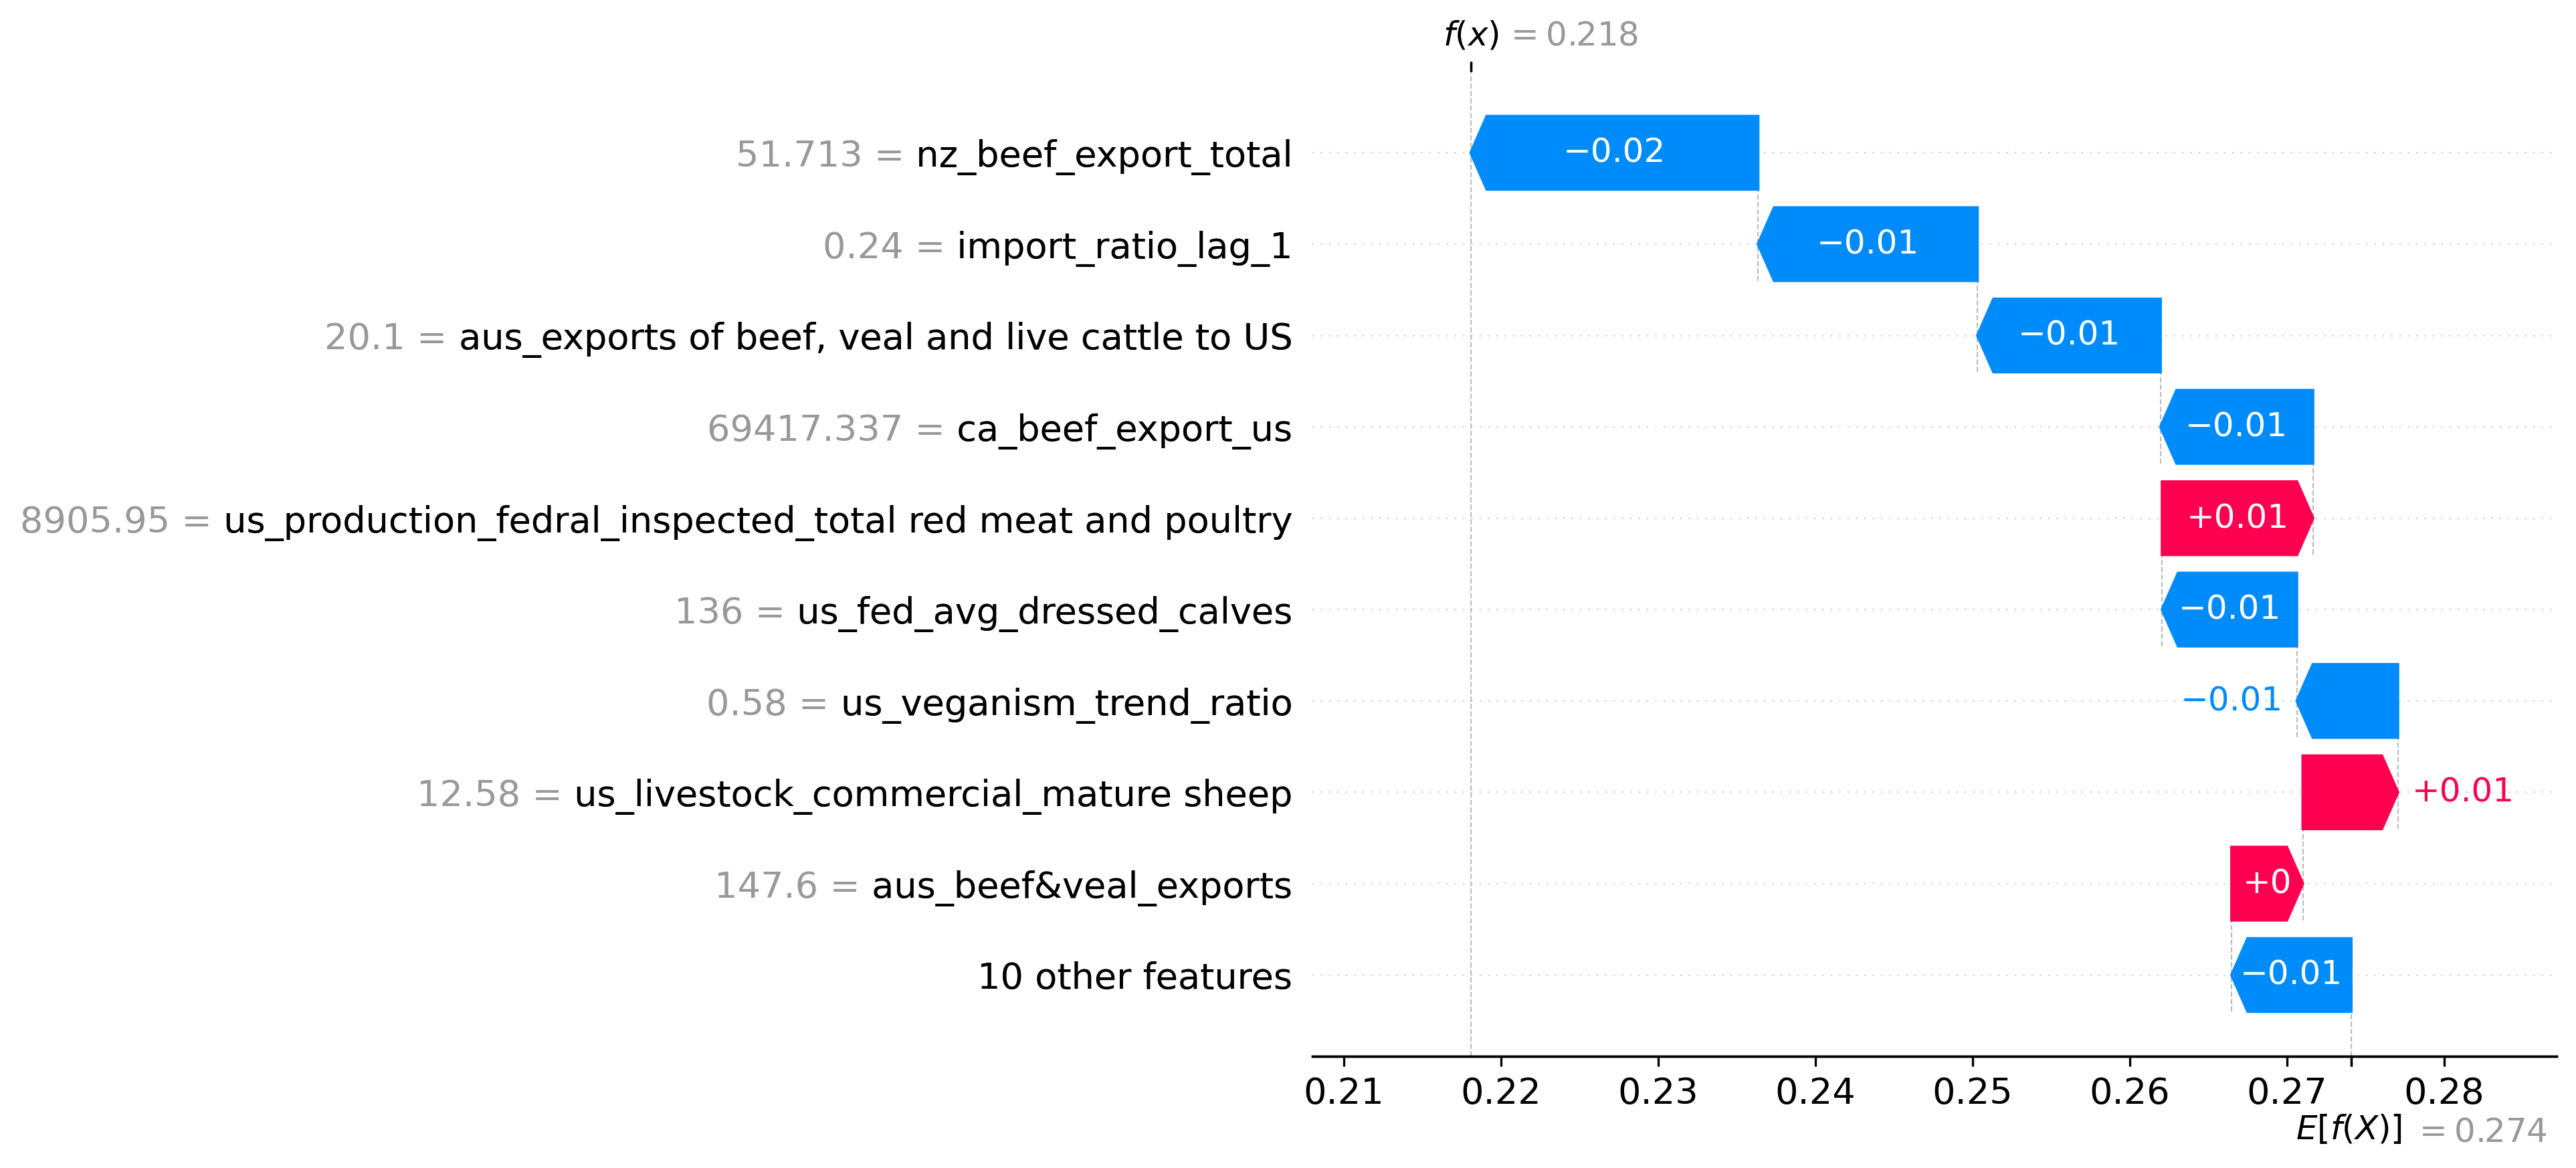

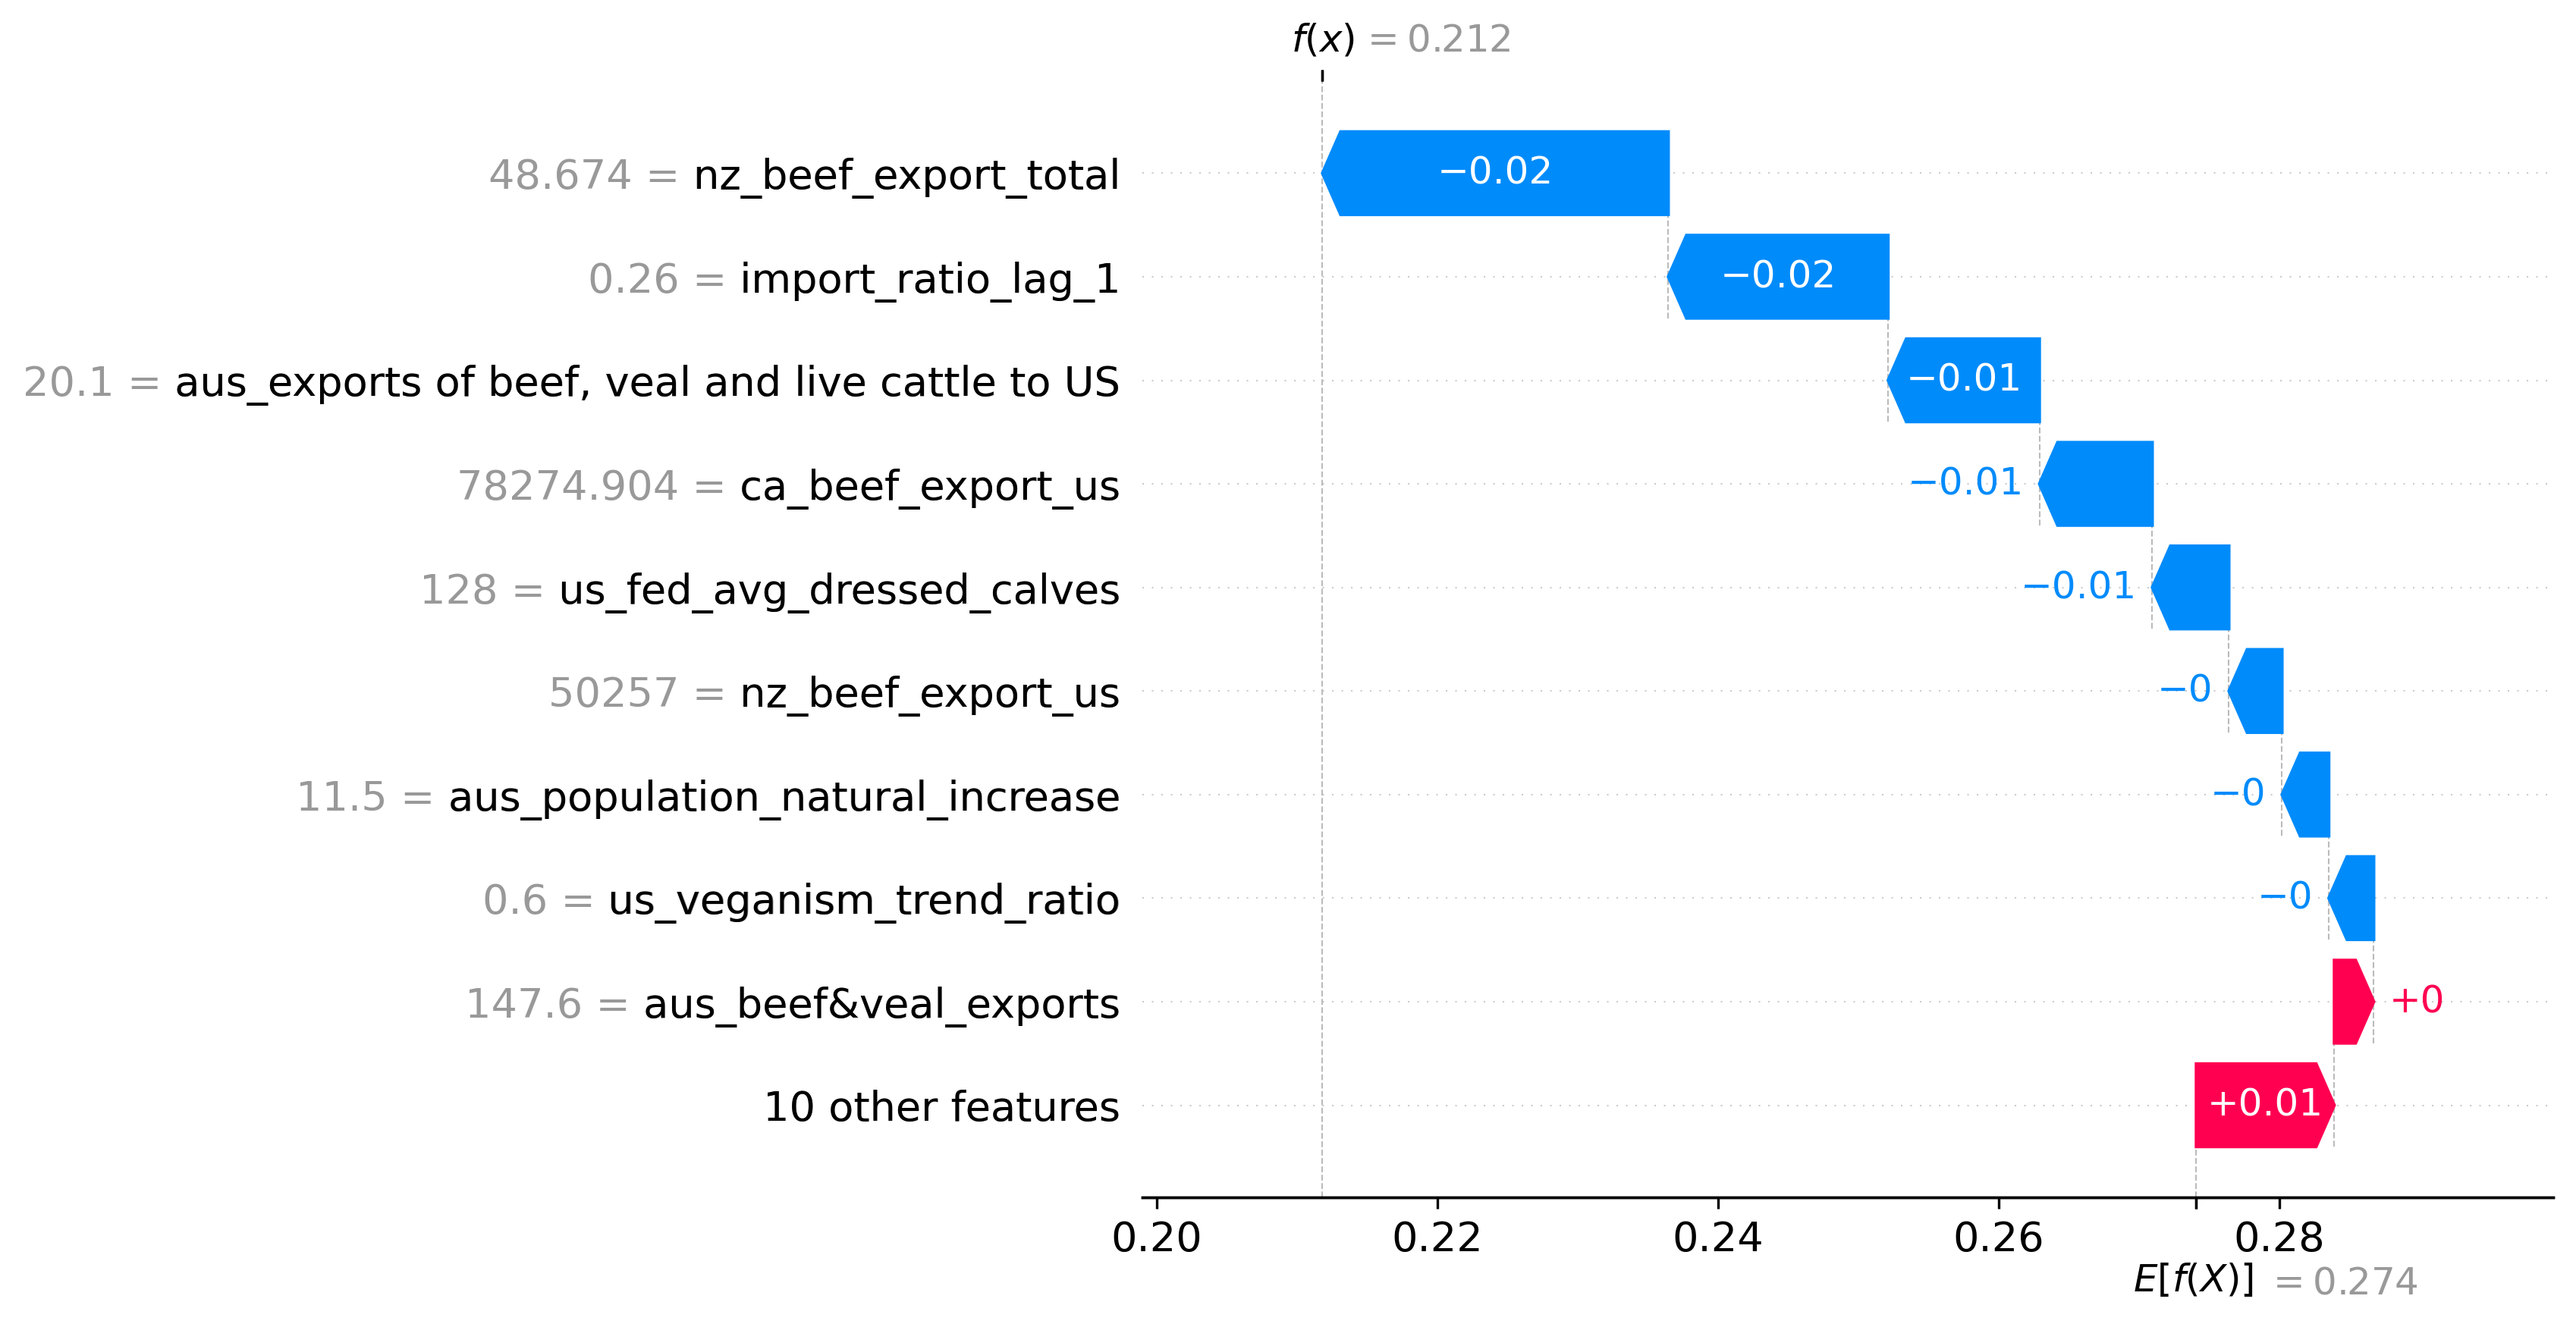

In [64]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values_has_outlier[0])
#shap.plots.waterfall(shap_values_has_outlier[1])
#shap.plots.waterfall(shap_values_has_outlier[2])
#shap.plots.waterfall(shap_values_has_outlier[3])
shap.plots.waterfall(shap_values_has_outlier[4])
shap.plots.waterfall(shap_values_has_outlier[5])

In [57]:
# visualize a single(first) prediction's explanation with a force plot
shap.plots.force(shap_values_has_outlier[0])

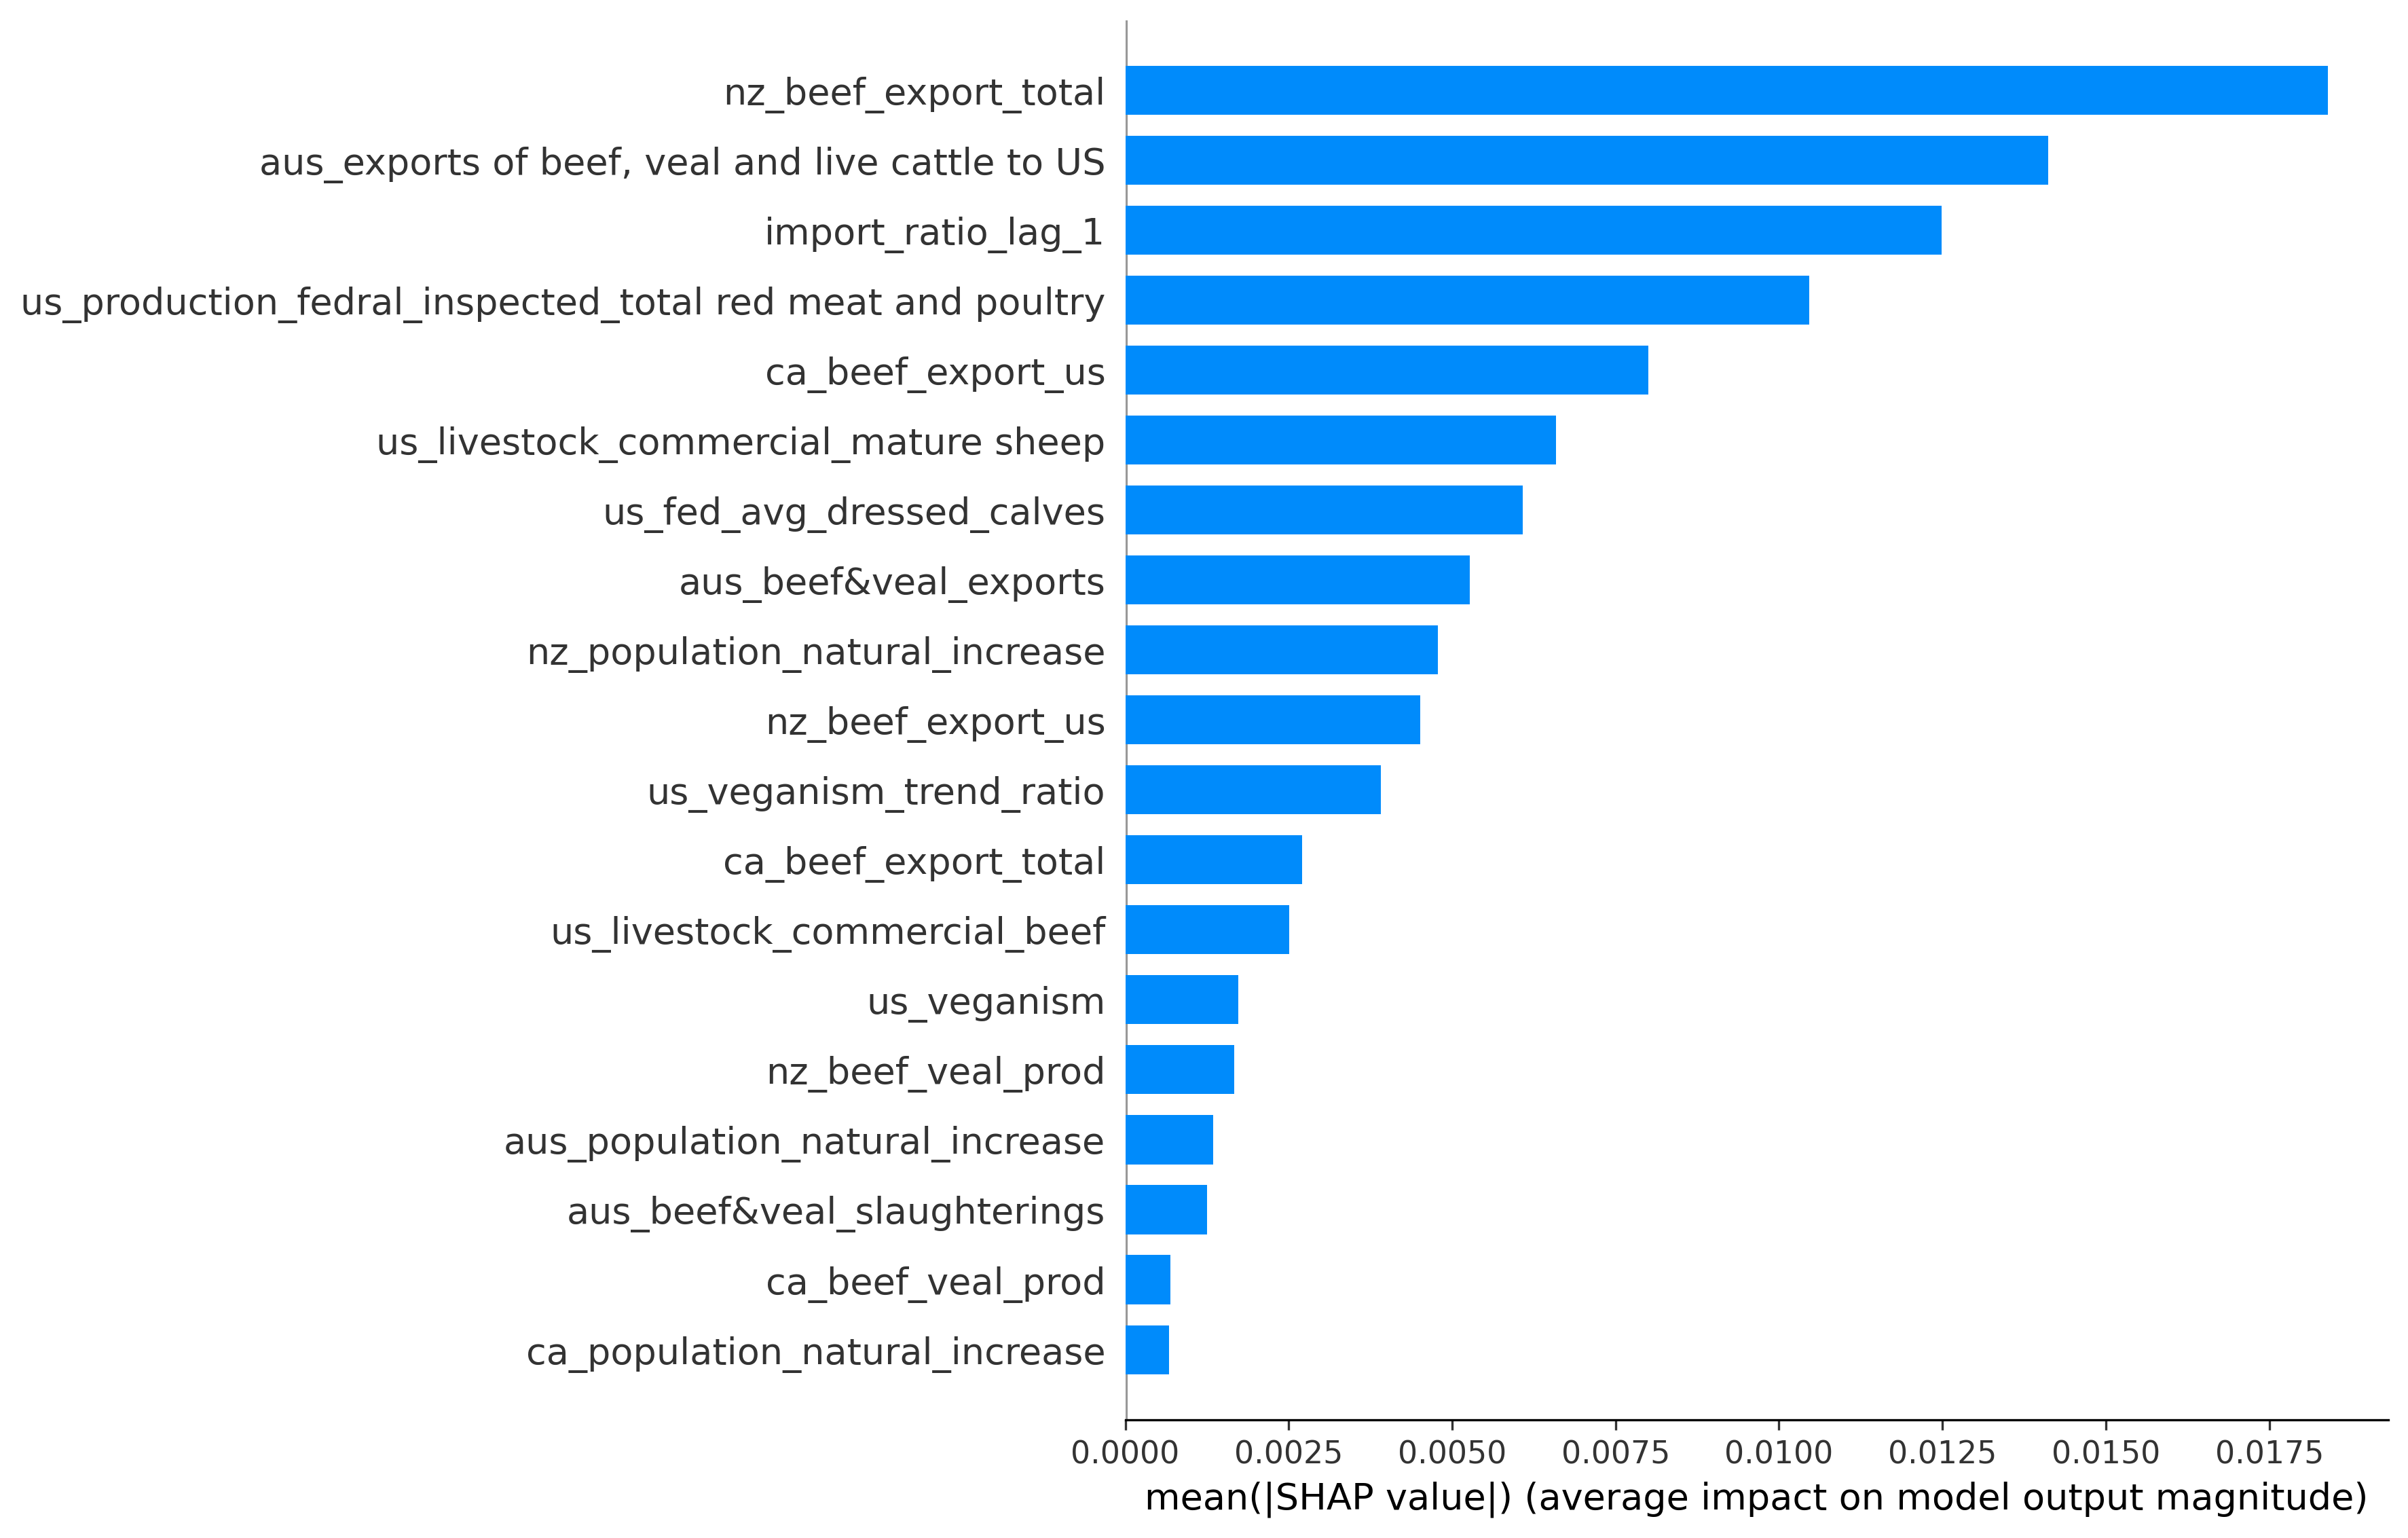

In [19]:
shap.summary_plot(shap_values_has_outlier, best_X_test_lag,plot_type="bar", show=False)
plt.savefig("12M_competitor_rank.pdf", format='pdf', dpi=1000, bbox_inches='tight')

In [16]:
def global_shap_importance(model, X):
    """ Return a dataframe containing the features sorted by Shap importance
    Parameters
    ----------
    model : The tree-based model 
    X : pd.Dataframe
         training set/test set/the whole dataset ... (without the label)
    Returns
    -------
    pd.Dataframe
        A dataframe containing the features sorted by Shap importance
    """
    explainer = shap.Explainer(model)
    shap_values = explainer(X)
    cohorts = {"": shap_values}
    cohort_labels = list(cohorts.keys())
    cohort_exps = list(cohorts.values())
    for i in range(len(cohort_exps)):
        if len(cohort_exps[i].shape) == 2:
            cohort_exps[i] = cohort_exps[i].abs.mean(0)
    features = cohort_exps[0].data
    feature_names = cohort_exps[0].feature_names
    values = np.array([cohort_exps[i].values for i in range(len(cohort_exps))])
    feature_importance = pd.DataFrame(
        list(zip(feature_names, sum(values))), columns=['features', 'importance'])
    feature_importance.sort_values(
        by=['importance'], ascending=False, inplace=True)
    return feature_importance

out1 = global_shap_importance(best_model, best_X_test_lag)
#out1.to_csv("old_12m_shap_rank.csv")
out1

,features,importance
14,nz_beef_export_total,0.018396
4,"aus_exports of beef, veal and live cattle to US",0.014122
18,import_ratio_lag_1,0.012483
3,us_production_fedral_inspected_total red meat ...,0.010467
12,ca_beef_export_us,0.008001
5,us_livestock_commercial_mature sheep,0.006594
8,us_fed_avg_dressed_calves,0.006081
2,aus_beef&veal_exports,0.005267
17,nz_population_natural_increase,0.004780
16,nz_beef_export_us,0.004508
